This notebook processes historical price data and sentiment scores from FinGPT, then backtests various trading strategies over 2022–2023 to test whether FinGPT’s sentiment insights improve trading results.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import gc
import numpy as np
import math
import matplotlib.pyplot as plt

Mounted at /content/drive


### Process and load the data
This function reads multiple CSV files from a directory, combines the data into a single DataFrame, and then groups by minute to calculate a time-weighted average price (TWAP) and total volume for each minute. 

In [ ]:
def process_to_minute_bars(data_dir):
    # List all CSV files in the directory
    csv_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.csv')]

    # Initialize an empty list to hold DataFrames
    dataframes = []

    # Read each CSV file and append to the list
    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)

    # Concatenate all DataFrames into one
    mega_df = pd.concat(dataframes, ignore_index=True)

    # Ensure ClockTime is in datetime format
    mega_df['ClockTime'] = pd.to_datetime(mega_df['ClockTime'], errors='coerce')

    # Truncate ClockTime to minute level
    mega_df['MinuteTime'] = mega_df['ClockTime'].dt.floor('T')

    # Calculate minute-level TWAP
    minute_level_df = mega_df.groupby('MinuteTime').apply(
        lambda x: (x['TWAP'] * x['Volume']).sum() / x['Volume'].sum()
    ).reset_index(name='TWAP')

    # Calculate total volume for each minute
    minute_level_df['TotalVolume'] = mega_df.groupby('MinuteTime')['Volume'].sum().values

    # Clear large in-memory DataFrame to free RAM
    del mega_df,dataframes
    gc.collect()

    # Return the processed minute-level DataFrame
    return minute_level_df

In [ ]:
tickers = ['AMZN', 'AAPL', 'TSLA']
years = [2022, 2023]

# Dictionary to hold minute-level DataFrames for each ticker
minute_bars = {}

for ticker in tickers:
    for year in years:
        data_dir = f'/content/drive/My Drive/{year}/{ticker}/'
        print(f"Processing data for {ticker} ({year})...")
        try:
            # Process minute bars for the current ticker and year
            minute_bars[f"{ticker}_{year}"] = process_to_minute_bars(data_dir)
        except Exception as e:
            print(f"Failed to process {ticker} ({year}): {e}")

### Clean up for stock split
During the backtesting period, there were corporate actions (stock splits) that were not handled by the Alpaca API and thus we adjust the stock prices before we proceed

In [4]:
# TSLA 2022
tsla_2022_minute_level_df = minute_bars['TSLA_2022']
split_timestamp = pd.Timestamp('2022-08-25 9:30:00')
split_ratio = 3

# Adjust TWAP and Volume for rows before the split
tsla_2022_minute_level_df.loc[tsla_2022_minute_level_df['MinuteTime'] < split_timestamp, 'TWAP'] /= split_ratio
tsla_2022_minute_level_df.loc[tsla_2022_minute_level_df['MinuteTime'] < split_timestamp, 'TotalVolume'] *= split_ratio

In [5]:
# AMZN 2022
amzn_2022_minute_level_df = minute_bars['AMZN_2022']
split_timestamp = pd.Timestamp('2022-06-06 9:30:00')
split_ratio = 20

# Adjust TWAP and Volume for rows before the split
amzn_2022_minute_level_df.loc[amzn_2022_minute_level_df['MinuteTime'] < split_timestamp, 'TWAP'] /= split_ratio
amzn_2022_minute_level_df.loc[amzn_2022_minute_level_df['MinuteTime'] < split_timestamp, 'TotalVolume'] *= split_ratio

### Backtest function - baseline
This function simulates a simple trading strategy using buy/sell signals, keeps track of all trades, and calculates various performance metrics to evaluate the strategy’s profitability and risk. Below is a brief explanation of each returned metric.

Total Trades: The total number of trades executed during the backtest. This indicates how frequently the strategy trades.  

Total PnL: The overall profit or loss generated by the strategy at the end of the backtest period.  

Annualized Sharpe: The Sharpe ratio, adjusted to a yearly scale, measuring the strategy’s excess return per unit of volatility. A higher value generally indicates a better risk-adjusted return.  

Win Ratio: The percentage of all executed trades that resulted in a profit, reflecting how often the strategy wins compared to loses.  

Profit Factor (Avg_Win / Avg_Loss): The ratio of the average profit from winning trades to the average loss from losing trades, showing if winners are on average larger than losers.  

Max Drawdown: The maximum observed loss from a peak to a trough in the cumulative PnL, indicating the worst decline the strategy experienced during the test.  
Cumulative PnL: A time series of the running total profit and loss, allowing you to see how the strategy’s performance evolved over time.  

In [ ]:
def backtest_base_strategy(df, initial_cash=1_000_000, trade_amount=100_000, risk_limit=1_000_000):
    # Initialize variables
    cash = initial_cash
    position_size = 0
    avg_price = 0
    trade_log = []
    daily_pnl = {}
    cumulative_pnl = [0]

    for i in range(1, len(df)):
        current_signal = df.loc[i, 'Signal']
        current_price = df.loc[i, 'TWAP']
        current_date = df.loc[i, 'MinuteTime'].date()

        if np.isnan(current_price) or current_price <= 0:
            continue

        # Trade logic
        if current_signal == 1:
            if position_size < 0:
                pnl = ((avg_price - current_price) / avg_price) * abs(position_size)
                trade_log.append(pnl)
                cumulative_pnl.append(cumulative_pnl[-1] + pnl)
                daily_pnl[current_date] = daily_pnl.get(current_date, 0) + pnl
                cash += abs(position_size)
                position_size = 0
                avg_price = 0

            if position_size + trade_amount <= risk_limit and cash >= trade_amount:
                cash -= trade_amount
                avg_price = (avg_price * position_size + current_price * trade_amount) / (position_size + trade_amount)
                position_size += trade_amount

        elif current_signal == -1:
            if position_size > 0:
                pnl = ((current_price - avg_price) / avg_price) * position_size
                trade_log.append(pnl)
                cumulative_pnl.append(cumulative_pnl[-1] + pnl)
                daily_pnl[current_date] = daily_pnl.get(current_date, 0) + pnl
                cash += position_size
                position_size = 0
                avg_price = 0

            if abs(position_size - trade_amount) <= risk_limit and cash >= trade_amount:
                cash -= trade_amount
                avg_price = (avg_price * abs(position_size) + current_price * trade_amount) / (abs(position_size) + trade_amount)
                position_size -= trade_amount

    if position_size != 0:
        final_price = df['TWAP'].iloc[-1]
        if position_size > 0:
            final_pnl = ((final_price - avg_price) / avg_price) * position_size
        else:
            final_pnl = ((avg_price - final_price) / avg_price) * abs(position_size)
        trade_log.append(final_pnl)
        cumulative_pnl.append(cumulative_pnl[-1] + final_pnl)
        daily_pnl[current_date] = daily_pnl.get(current_date, 0) + final_pnl
        cash += abs(position_size)
        position_size = 0

    daily_pnl_values = np.array(list(daily_pnl.values()))
    daily_return = 0.96 * daily_pnl_values / 2000000  # Adjusted for transaction costs

    cumulative_pnl = np.array(cumulative_pnl)
    drawdowns = cumulative_pnl - np.maximum.accumulate(cumulative_pnl)
    max_drawdown = -np.min(drawdowns)

    total_pnl = sum(trade_log)
    total_return = 0.96 * total_pnl / 2000000
    avg_daily_return = np.mean(daily_return) if len(daily_return) > 0 else 0
    std_daily_return = np.std(daily_return) if len(daily_return) > 0 else 0
    sharpe_ratio = (
        (avg_daily_return - 0.05 / 252) / std_daily_return * math.sqrt(252)
        if std_daily_return != 0 else np.nan
    )
    win_ratio = sum(1 for pnl in trade_log if pnl > 0) / len(trade_log) if trade_log else 0
    avg_win = np.mean([pnl for pnl in trade_log if pnl > 0]) if trade_log else 0
    avg_loss = np.mean([abs(pnl) for pnl in trade_log if pnl < 0]) if trade_log else 1e-8
    profit_factor = avg_win / avg_loss if avg_loss != 0 else np.nan

    return {
        'Total Trades': len(trade_log),
        'Total PnL': total_pnl,
        'Annualized Sharpe': sharpe_ratio,
        'Win Ratio': win_ratio,
        'Profit Factor (Avg_Win / Avg_Loss)': profit_factor,
        'Max Drawdown': max_drawdown,
        'Cumulative PnL': cumulative_pnl,
    }


### Backtest function - augmented 
This function simulates a more flexible trading strategy that opens and closes positions based on a new sentiment signal. The position size varies depending on the strength of the signal. After running all the trades, it calculates several performance metrics to gauge the strategy’s effectiveness. Below are brief explanations of each metric.

Total Trades: The total number of trades made during the backtest, indicating how often the strategy enters or exits the market.  

Total PnL: The net profit or loss generated over the entire backtest period.  

Annualized Sharpe: The Sharpe ratio scaled to a yearly basis, showing the strategy’s risk-adjusted return. A higher Sharpe typically means better performance.  

Aggregated Win Ratio: The fraction of all trades that were profitable, giving a broad view of the strategy’s overall success rate.  

Win Ratio Positive: The fraction of profitable trades among those executed when the strategy was signaled to go long (positive sentiment).  

Win Ratio Negative: The fraction of profitable trades among those executed when the strategy was signaled to go short (negative sentiment).  

Profit Factor (Avg_Win / Avg_Loss): The ratio of the average gain from winning trades to the average loss from losing trades, indicating if winning trades on average outweighed losing trades.  

Max Drawdown: The largest observed decline from a peak in cumulative PnL, highlighting the worst-case scenario for losses during the trading period.  

Cumulative PnL: A time-series of running total profit and loss, allowing you to observe the strategy’s performance trajectory over time.

In [ ]:
def backtest_new_strategy(df, initial_cash=1_000_000, risk_limit=1_000_000):
    # Initialize variables
    cash = initial_cash
    position_size = 0  # Total dollar value of the position (positive = long, negative = short)
    avg_price = 0  # Average price of the position
    trade_log = []  # Track PnL of each trade
    positive_trades = []  # Track PnL of positive sentiment trades
    negative_trades = []  # Track PnL of negative sentiment trades
    daily_pnl = {}  # To store aggregated PnL by day
    cumulative_pnl = [0]  # Cumulative PnL for max drawdown

    for i in range(1, len(df)):  # Start from the second row
        current_signal = df.loc[i, 'new_signal']
        current_price = df.loc[i, 'TWAP']
        current_date = df.loc[i, 'MinuteTime'].date()  # Extract date

        # Skip rows with NaN or invalid price
        if np.isnan(current_price) or current_price <= 0:
            continue

        # Determine trade amount based on signal strength
        if abs(current_signal) == 1:
            trade_amount = 0.1 * initial_cash
        elif abs(current_signal) == 2:
            trade_amount = 0.15 * initial_cash
        else:
            continue  # Skip if no valid signal

        # Trade logic
        if current_signal > 0:  # Long signal
            if position_size < 0:  # Flip from short to long
                pnl = ((avg_price - current_price) / avg_price) * abs(position_size)
                trade_log.append(pnl)
                positive_trades.append(pnl)
                cumulative_pnl.append(cumulative_pnl[-1] + pnl)
                daily_pnl[current_date] = daily_pnl.get(current_date, 0) + pnl
                cash += abs(position_size)  # Close short
                position_size = 0
                avg_price = 0

            # Open or increase long position
            if position_size + trade_amount <= risk_limit and cash >= trade_amount:
                cash -= trade_amount
                avg_price = (avg_price * position_size + current_price * trade_amount) / (position_size + trade_amount)
                position_size += trade_amount

        elif current_signal < 0:  # Short signal
            if position_size > 0:  # Flip from long to short
                pnl = ((current_price - avg_price) / avg_price) * position_size
                trade_log.append(pnl)
                negative_trades.append(pnl)
                cumulative_pnl.append(cumulative_pnl[-1] + pnl)
                daily_pnl[current_date] = daily_pnl.get(current_date, 0) + pnl
                cash += position_size  # Close long
                position_size = 0
                avg_price = 0

            # Open or increase short position
            if abs(position_size - trade_amount) <= risk_limit and cash >= trade_amount:
                cash -= trade_amount
                avg_price = (avg_price * abs(position_size) + current_price * trade_amount) / (abs(position_size) + trade_amount)
                position_size -= trade_amount

    # Final PnL (close any open positions at the last price)
    if position_size != 0:
        final_price = df['TWAP'].iloc[-1]
        if position_size > 0:  # Closing long position
            final_pnl = ((final_price - avg_price) / avg_price) * position_size
            positive_trades.append(final_pnl)
        else:  # Closing short position
            final_pnl = ((avg_price - final_price) / avg_price) * abs(position_size)
            negative_trades.append(final_pnl)
        trade_log.append(final_pnl)
        cumulative_pnl.append(cumulative_pnl[-1] + final_pnl)
        daily_pnl[current_date] = daily_pnl.get(current_date, 0) + final_pnl
        cash += abs(position_size)
        position_size = 0

    daily_pnl_values = np.array(list(daily_pnl.values()))
    daily_return = 0.96 * daily_pnl_values / 2000000  # Adjusted for transaction costs

    cumulative_pnl = np.array(cumulative_pnl)
    drawdowns = cumulative_pnl - np.maximum.accumulate(cumulative_pnl)
    max_drawdown = -np.min(drawdowns)

    total_pnl = sum(trade_log)
    total_return = 0.96 * total_pnl / 2000000
    avg_daily_return = np.mean(daily_return) if len(daily_return) > 0 else 0
    std_daily_return = np.std(daily_return) if len(daily_return) > 0 else 0
    sharpe_ratio = (
        (avg_daily_return - 0.05 / 252) / std_daily_return * math.sqrt(252)
        if std_daily_return != 0 else np.nan
    )
    win_ratio_positive = sum(1 for pnl in positive_trades if pnl > 0) / len(positive_trades) if positive_trades else 0
    win_ratio_negative = sum(1 for pnl in negative_trades if pnl > 0) / len(negative_trades) if negative_trades else 0
    aggregated_win_ratio = sum(1 for pnl in trade_log if pnl > 0) / len(trade_log) if trade_log else 0
    avg_win = np.mean([pnl for pnl in trade_log if pnl > 0]) if trade_log else 0
    avg_loss = np.mean([abs(pnl) for pnl in trade_log if pnl < 0]) if trade_log else 1e-8
    profit_factor = avg_win / avg_loss if avg_loss != 0 else np.nan

    return {
        'Total Trades': len(trade_log),
        'Total PnL': total_pnl,
        'Annualized Sharpe': sharpe_ratio,
        'Aggregated Win Ratio': aggregated_win_ratio,
        'Win Ratio Positive': win_ratio_positive,
        'Win Ratio Negative': win_ratio_negative,
        'Profit Factor (Avg_Win / Avg_Loss)': profit_factor,
        'Max Drawdown': max_drawdown,
        'Cumulative PnL': cumulative_pnl,
    }


### Signal modifier function
This function sets a new_signal value based on sentiment and signal conditions for a given ticker. Positive sentiment with a buy signal gets 1 or 2 depending on the logit threshold, while negative sentiment with a sell signal gets -1 or -2.

In [ ]:
def modify_signal(df, ticker):
    # Construct column names dynamically
    sentiment_col = f"{ticker}_sentiment"
    logit_col = f"{ticker}_logit"

    # Initialize 'new_signal' column with 0
    df['new_signal'] = 0

    # Apply the conditions for 'new_signal'
    df.loc[
        (df[sentiment_col] == 'Positive') &
        (df['Signal'] == 1) &
        (df[logit_col] < 0.5),
        'new_signal'
    ] = 1

    df.loc[
        (df[sentiment_col] == 'Positive') &
        (df['Signal'] == 1) &
        (df[logit_col] >= 0.5),
        'new_signal'
    ] = 2

    df.loc[
        (df[sentiment_col] == 'Negative') &
        (df['Signal'] == -1) &
        (df[logit_col] < 0.5),
        'new_signal'
    ] = -1

    df.loc[
        (df[sentiment_col] == 'Negative') &
        (df['Signal'] == -1) &
        (df[logit_col] >= 0.5),
        'new_signal'
    ] = -2

    return df


### Load sentiment data

In [ ]:
def load_sentiment_data(base_dir, tickers, years):
    sentiment_data = {}

    for ticker in tickers:
        for year in years:
            file_path = os.path.join(base_dir, f"{ticker}_{year}.parquet")
            if os.path.exists(file_path):
                sentiment_data[f"{ticker}_{year}"] = pd.read_parquet(file_path)
                print(f"Loaded sentiment data for {ticker} {year}.")
            else:
                print(f"File not found: {file_path}")

    return sentiment_data

base_dir = '/content/drive/My Drive/historical_reddit/'
tickers = ['TSLA', 'AAPL', 'AMZN']
years = [2022, 2023]

sentiment_data_dict = load_sentiment_data(base_dir, tickers, years)

Loaded sentiment data for TSLA 2022.
Loaded sentiment data for TSLA 2023.
Loaded sentiment data for AAPL 2022.
Loaded sentiment data for AAPL 2023.
Loaded sentiment data for AMZN 2022.
Loaded sentiment data for AMZN 2023.


### Merge sentiment with price data
Merge sentiment data with minute-level data and adjust for execution delay - in our set up, it is 1 minute

In [ ]:
def merge_sentiment(minute_df, sentiment_df, ticker):
    # Ensure timestamp columns are in datetime format
    sentiment_df['timestamp'] = pd.to_datetime(sentiment_df['timestamp'])
    minute_df['MinuteTime'] = pd.to_datetime(minute_df['MinuteTime'])

    # Merge with a left join using asof merge
    merged_df = pd.merge_asof(
        minute_df.sort_values('MinuteTime'),
        sentiment_df.sort_values('timestamp'),
        left_on='MinuteTime',
        right_on='timestamp',
        direction='backward'
    )

    # Shift sentiment columns to simulate delay in execution
    sentiment_col = f'{ticker}_sentiment'
    logit_col = f'{ticker}_logit'
    merged_df[sentiment_col] = merged_df[sentiment_col].shift(1).fillna('Neutral')
    merged_df[logit_col] = merged_df[logit_col].shift(1).fillna(1)

    return merged_df

### Moving Average Crossover
Fast window = 5  
Slow window = 30  
Long = fast crosses slow from below  
Short = slow crosses fast from above  

The moving average crossover strategy is a technical analysis method used to identify trends and generate trading signals. In this setup, the Fast EMA (10-period) represents the short-term trend, while the Slow EMA (30-period) captures the longer-term trend. A Long position is initiated when the Fast EMA crosses above the Slow EMA, indicating upward momentum and a potential bullish trend. Conversely, a Short position is initiated when the Slow EMA crosses above the Fast EMA, signaling downward momentum and a potential bearish trend. This combination of short and long EMAs allows for a balance between responsiveness to short-term price changes and smoothing out noise, making it suitable for minute-level trading strategies.

In [11]:
def sma_signal(df, fast_window=5, slow_window=30):
    """
    Generates SMA crossover signals for a given DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the TWAP column.
        fast_window (int): Window size for the fast SMA.
        slow_window (int): Window size for the slow SMA.

    Returns:
        pd.DataFrame: Updated DataFrame with Fast_SMA, Slow_SMA, and Signal columns.
    """
    # Calculate SMAs
    df['Fast_SMA'] = df['TWAP'].rolling(window=fast_window, min_periods=fast_window).mean()
    df['Slow_SMA'] = df['TWAP'].rolling(window=slow_window, min_periods=slow_window).mean()

    # Initialize Signal column
    df['Signal'] = 0

    # Detect bullish crossover (Fast crosses Slow from below)
    df.loc[
        (df['Fast_SMA'] > df['Slow_SMA']) &
        (df['Fast_SMA'].shift(1) <= df['Slow_SMA'].shift(1)),
        'Signal'
    ] = 1  # Long

    # Detect bearish crossover (Fast crosses Slow from above)
    df.loc[
        (df['Fast_SMA'] < df['Slow_SMA']) &
        (df['Fast_SMA'].shift(1) >= df['Slow_SMA'].shift(1)),
        'Signal'
    ] = -1  # Short

    return df

TSLA - 2022

Backtest Results:
Total Trades: 3799
Total PnL: 221256.36294216444
Annualized Sharpe: 1.9895239627059313
Win Ratio: 0.32219005001316137
Profit Factor (Avg_Win / Avg_Loss): 2.6091028915726144
Max Drawdown: 30605.069583449353


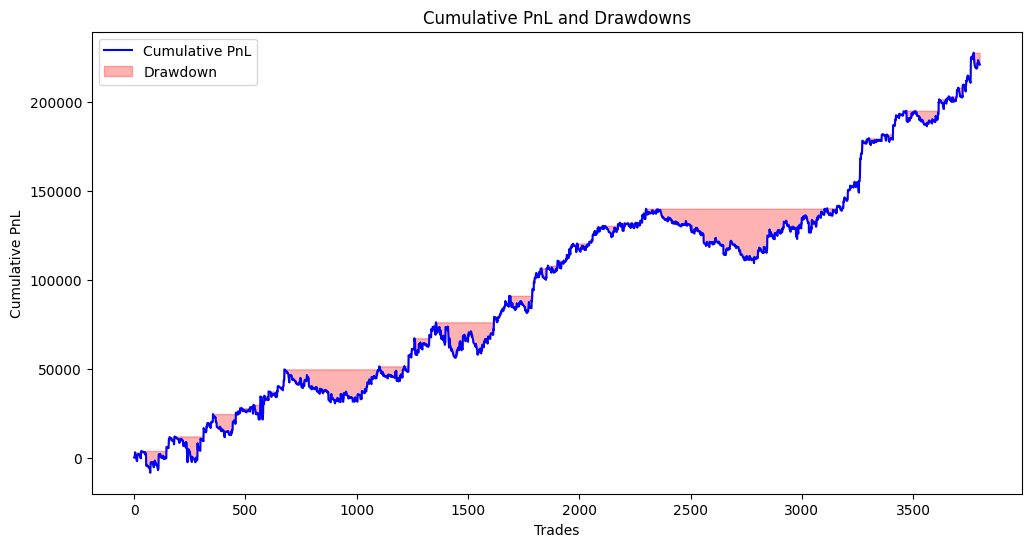

In [12]:
tsla_2022_minute_level_df = minute_bars['TSLA_2022']
tsla_2022_df = sma_signal(tsla_2022_minute_level_df)
# Run the backtest
results = backtest_base_strategy(tsla_2022_df)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 163
Total PnL: 720917.7396355878
Annualized Sharpe: 4.23706389459611
Aggregated Win Ratio: 0.5705521472392638
Win Ratio Positive: 0.5975609756097561
Win Ratio Negative: 0.5432098765432098
Profit Factor (Avg_Win / Avg_Loss): 2.105449045012951
Max Drawdown: 80155.86092178192


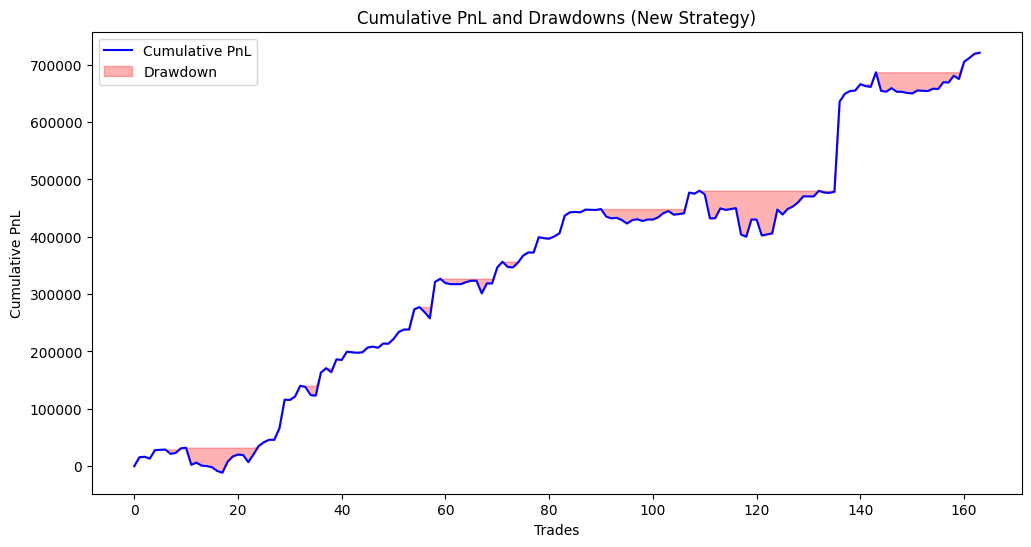

In [13]:
# Run the backtest
tsla_merged_2022 = merge_sentiment(tsla_2022_df,sentiment_data_dict['TSLA_2022'],'TSLA')
tsla_merged_2022 = modify_signal(tsla_merged_2022,'TSLA')
results = backtest_new_strategy(tsla_merged_2022)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

TSLA - 2023

TSLA 2022 Backtest Results:
Total Trades: 3854
Total PnL: 29681.4788484192
Annualized Sharpe: -1.3076799582927263
Win Ratio: 0.31785158277114683
Profit Factor (Avg_Win / Avg_Loss): 2.2219366150443682
Max Drawdown: 53141.60027811755


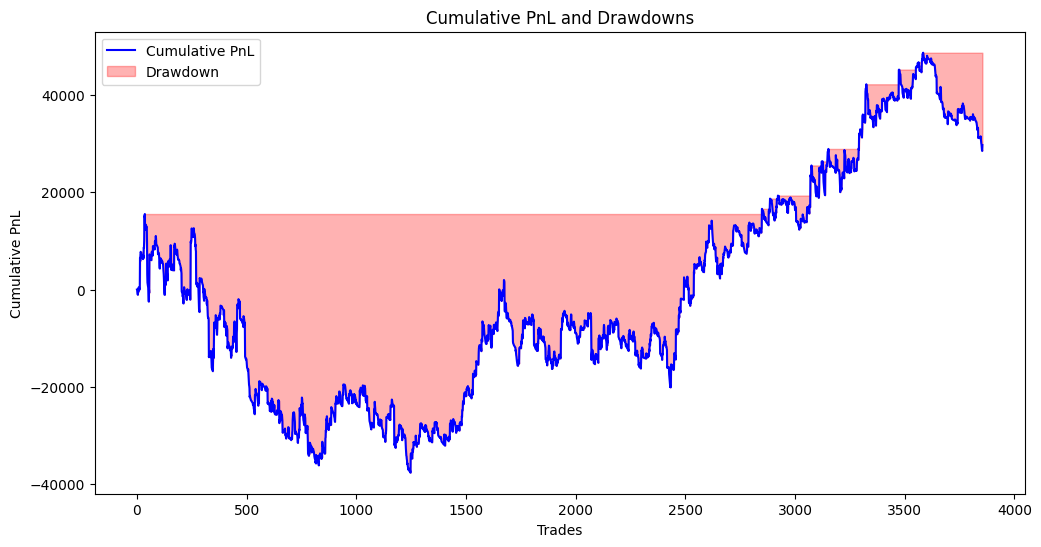

In [14]:
tsla_2023_minute_level_df = minute_bars['TSLA_2023']
tsla_2023_df = sma_signal(tsla_2023_minute_level_df)
# Run the backtest
results = backtest_base_strategy(tsla_2023_df)

# Print results
print("TSLA 2022 Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 226
Total PnL: 346838.645169418
Annualized Sharpe: 2.710749816638502
Aggregated Win Ratio: 0.5530973451327433
Win Ratio Positive: 0.5
Win Ratio Negative: 0.6071428571428571
Profit Factor (Avg_Win / Avg_Loss): 1.508778790115517
Max Drawdown: 57333.92451216071


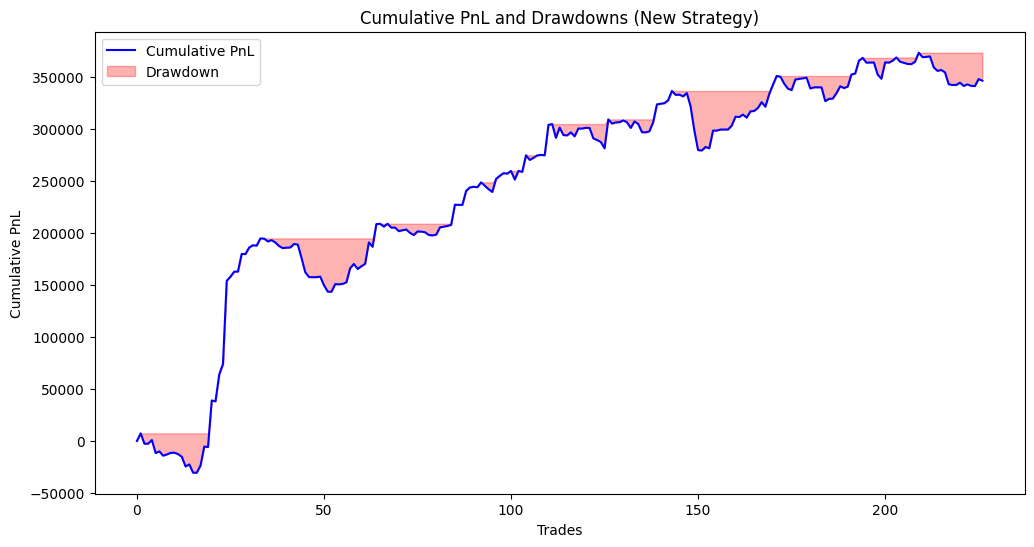

In [15]:
# Run the backtest
tsla_merged_2023 = merge_sentiment(tsla_2023_df,sentiment_data_dict['TSLA_2023'],'TSLA')
tsla_merged_2023 = modify_signal(tsla_merged_2023,'TSLA')
results = backtest_new_strategy(tsla_merged_2023)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

### AMZN - 2022

AMZN 2022 Backtest Results:
Total Trades: 3772
Total PnL: 18096.1256553432
Annualized Sharpe: -1.519523078096912
Win Ratio: 0.30116648992576883
Profit Factor (Avg_Win / Avg_Loss): 2.373216178202139
Max Drawdown: 43440.501053186475


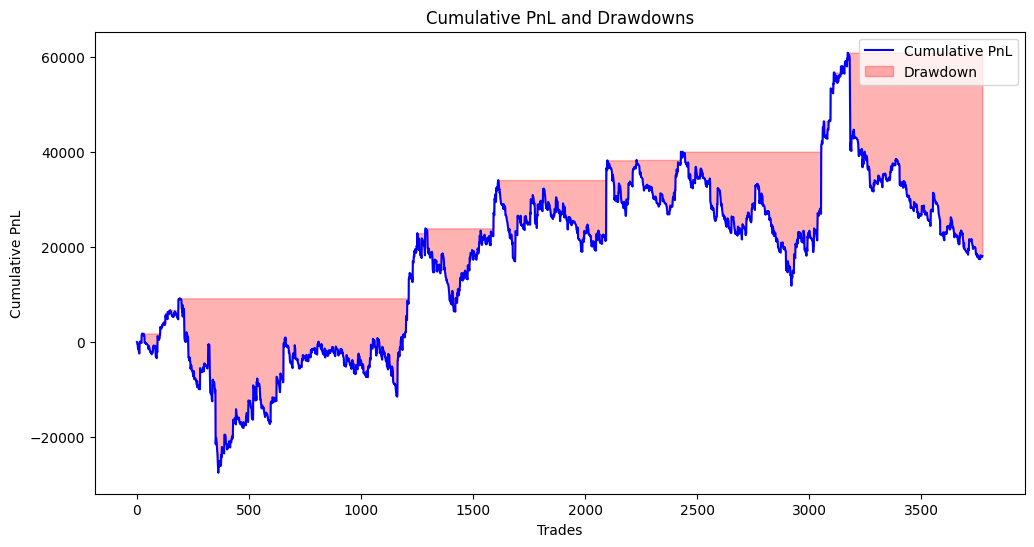

In [16]:
amzn_2022_minute_level_df = minute_bars['AMZN_2022']
amzn_2022_df = sma_signal(amzn_2022_minute_level_df)
# Run the backtest
results = backtest_base_strategy(amzn_2022_df)

# Print results
print("AMZN 2022 Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 67
Total PnL: 168625.4434392086
Annualized Sharpe: 2.2877552344113896
Aggregated Win Ratio: 0.5970149253731343
Win Ratio Positive: 0.696969696969697
Win Ratio Negative: 0.5
Profit Factor (Avg_Win / Avg_Loss): 1.1337670886382578
Max Drawdown: 101880.56069145455


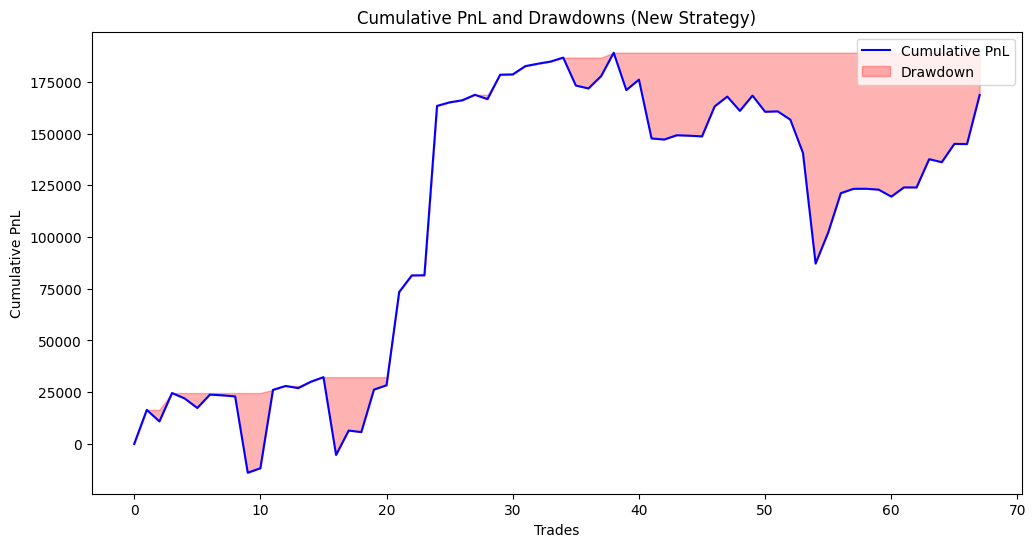

In [17]:
# Run the backtest
amzn_merged_2022 = merge_sentiment(amzn_2022_df,sentiment_data_dict['AMZN_2022'],'AMZN')
amzn_merged_2022 = modify_signal(amzn_merged_2022,'AMZN')
results = backtest_new_strategy(amzn_merged_2022)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

AMZN - 2023

AMZN 2023 Backtest Results:
Total Trades: 3865
Total PnL: -36497.52495083844
Annualized Sharpe: -4.011312867764235
Win Ratio: 0.2936610608020699
Profit Factor (Avg_Win / Avg_Loss): 2.2349225891363735
Max Drawdown: 70753.92890637126


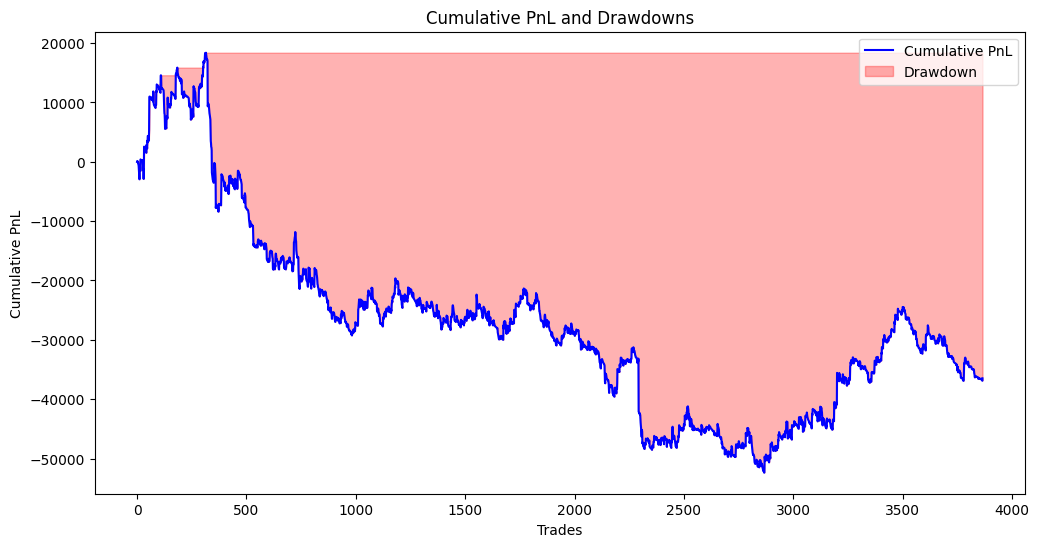

In [18]:
amzn_2023_minute_level_df = minute_bars['AMZN_2023']
amzn_2023_df = sma_signal(amzn_2023_minute_level_df)
# Run the backtest
results = backtest_base_strategy(amzn_2023_df)

# Print results
print("AMZN 2023 Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 56
Total PnL: 153571.66795602813
Annualized Sharpe: 4.018913757710198
Aggregated Win Ratio: 0.5357142857142857
Win Ratio Positive: 0.37037037037037035
Win Ratio Negative: 0.6896551724137931
Profit Factor (Avg_Win / Avg_Loss): 1.9136425953210252
Max Drawdown: 42672.31982509411


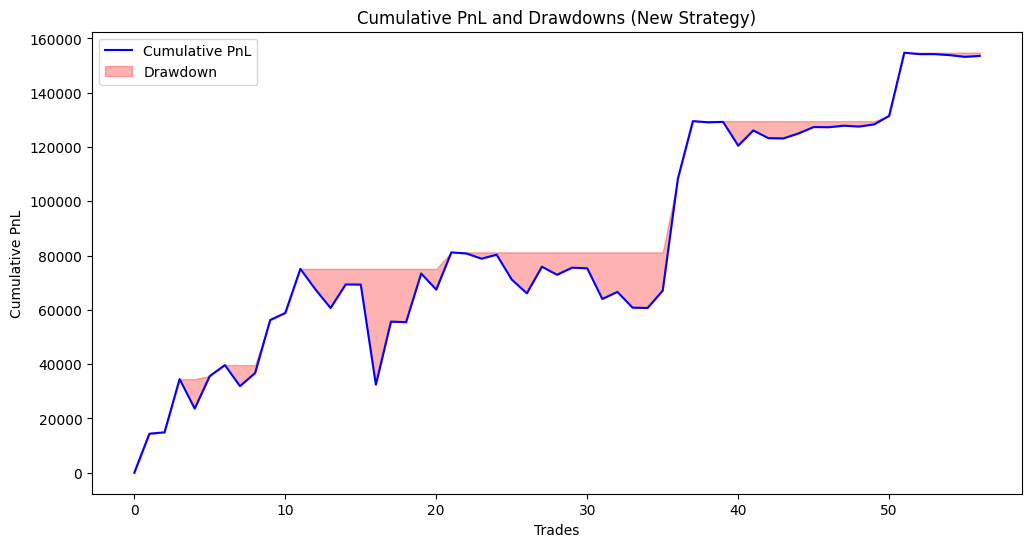

In [19]:
# Run the backtest
amzn_merged_2023 = merge_sentiment(amzn_2023_df,sentiment_data_dict['AMZN_2023'],'AMZN')
amzn_merged_2023 = modify_signal(amzn_merged_2023,'AMZN')
results = backtest_new_strategy(amzn_merged_2023)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

AAPL - 2022

AAPL 2022 Backtest Results:
Total Trades: 3964
Total PnL: -26953.657260466676
Annualized Sharpe: -4.060055339403882
Win Ratio: 0.3065085771947528
Profit Factor (Avg_Win / Avg_Loss): 2.1567674312895804
Max Drawdown: 57443.334419521605


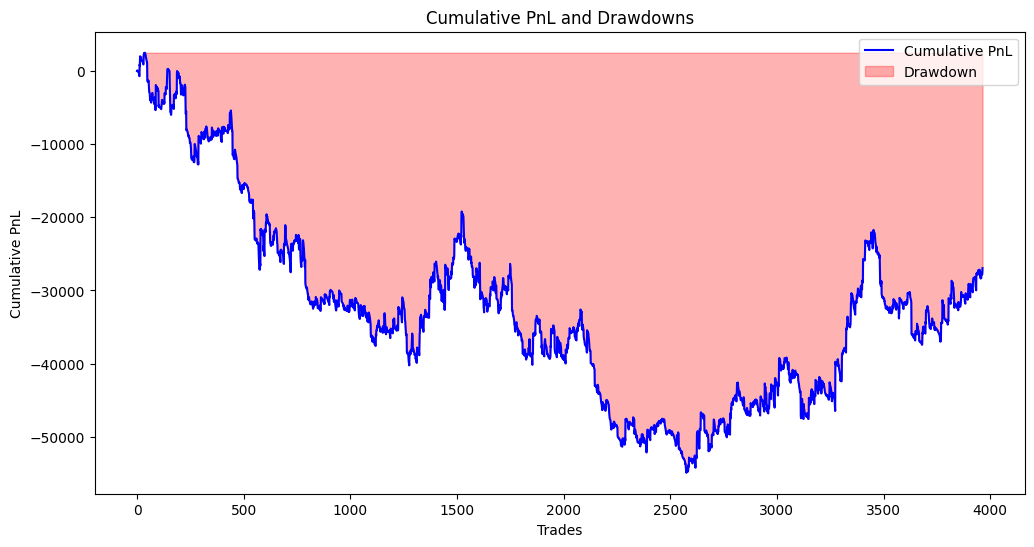

In [20]:
aapl_2022_minute_level_df = minute_bars['AAPL_2022']
aapl_2022_df = sma_signal(aapl_2022_minute_level_df)
# Run the backtest
results = backtest_base_strategy(aapl_2022_df)

# Print results
print("AAPL 2022 Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 89
Total PnL: 133373.75473379763
Annualized Sharpe: 2.087284065174375
Aggregated Win Ratio: 0.5393258426966292
Win Ratio Positive: 0.5454545454545454
Win Ratio Negative: 0.5333333333333333
Profit Factor (Avg_Win / Avg_Loss): 1.490868892889792
Max Drawdown: 62099.67184858165


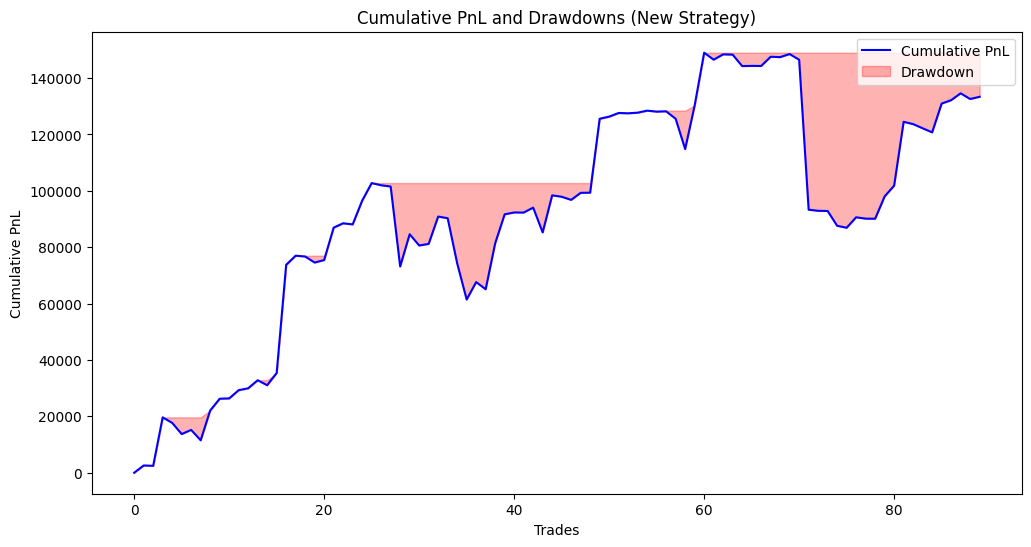

In [21]:
# Run the backtest
aapl_merged_2022 = merge_sentiment(aapl_2022_df,sentiment_data_dict['AAPL_2022'],'AAPL')
aapl_merged_2022 = modify_signal(aapl_merged_2022,'AAPL')
results = backtest_new_strategy(aapl_merged_2022)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

AAPL - 2023

AAPL 2023 Backtest Results:
Total Trades: 3865
Total PnL: -36497.52495083844
Annualized Sharpe: -4.011312867764235
Win Ratio: 0.2936610608020699
Profit Factor (Avg_Win / Avg_Loss): 2.2349225891363735
Max Drawdown: 70753.92890637126


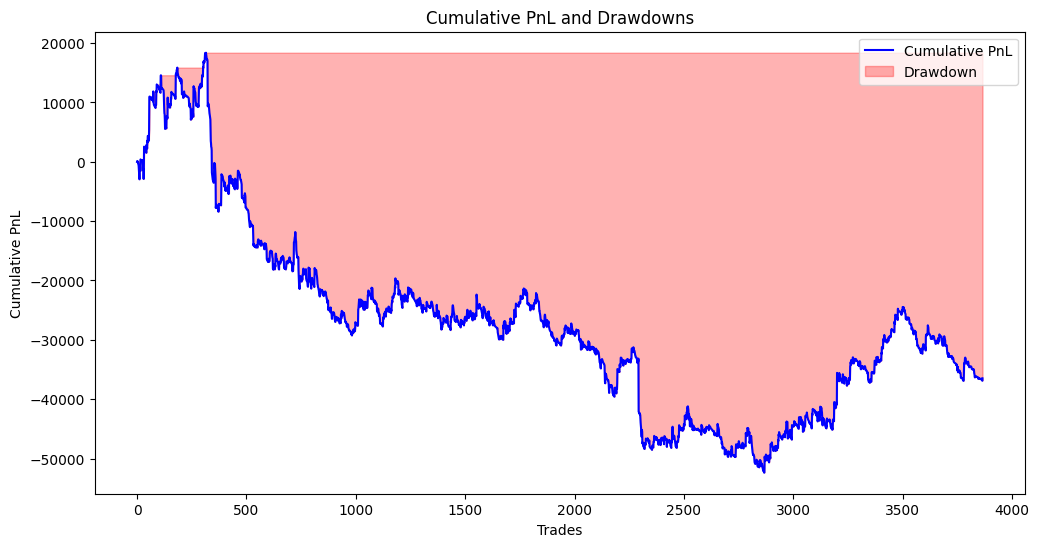

In [22]:
aapl_2023_minute_level_df = minute_bars['AAPL_2023']
aapl_2023_df = sma_signal(aapl_2023_minute_level_df)
# Run the backtest
results = backtest_base_strategy(amzn_2023_df)

# Print results
print("AAPL 2023 Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 118
Total PnL: 103716.07855074386
Annualized Sharpe: 2.1777577523787284
Aggregated Win Ratio: 0.559322033898305
Win Ratio Positive: 0.45
Win Ratio Negative: 0.6724137931034483
Profit Factor (Avg_Win / Avg_Loss): 1.5365488636895914
Max Drawdown: 43116.28526227095


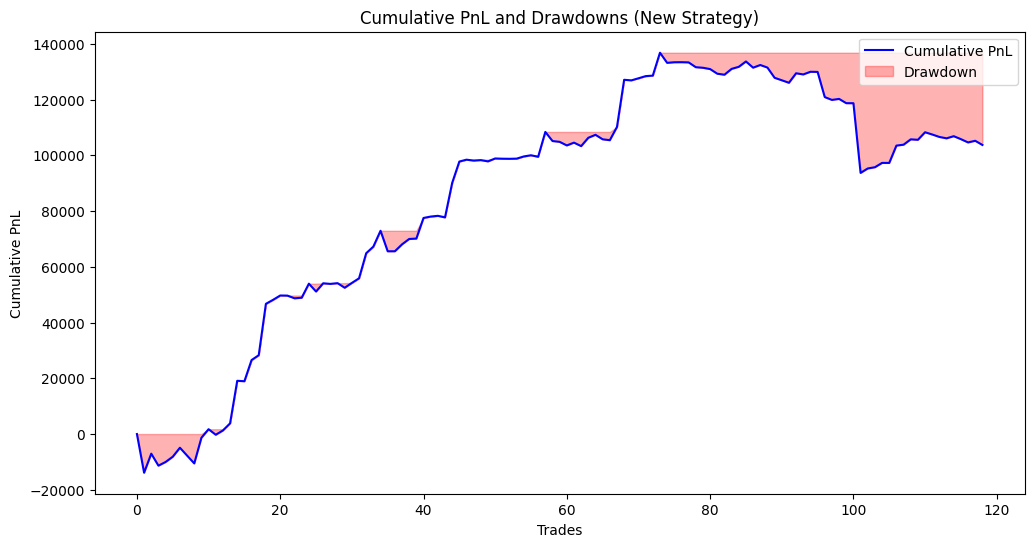

In [23]:
# Run the backtest
aapl_merged_2023 = merge_sentiment(aapl_2023_df,sentiment_data_dict['AAPL_2023'],'AAPL')
aapl_merged_2023 = modify_signal(aapl_merged_2023,'AAPL')
results = backtest_new_strategy(aapl_merged_2023)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

### Relative Strength Index (RSI)

The **Relative Strength Index (RSI)** is a momentum oscillator used to measure the speed and change of price movements, oscillating between 0 and 100. It is calculated using the following formula:

\[
RSI = 100 - \frac{100}{1 + RS}
\]

where \( RS = \frac{\text{Average Gain (over n periods)}}{\text{Average Loss (over n periods)}} \).

In this strategy, a **15-minute RSI** is employed to balance responsiveness with noise reduction. The key thresholds are:  
- **Oversold (30)**: A signal to buy is generated when RSI crosses **above 30**, indicating potential recovery from oversold levels.  
- **Overbought (70)**: A signal to sell is triggered when RSI crosses **below 70**, suggesting a possible reversal from overbought conditions.  

This setup aims to capture price momentum effectively while minimizing the risk of over-trading in highly volatile minute-level data.


In [24]:
def calculate_rsi_signal(df, period=15, overbought=70, oversold=30):
    """
    Calculate RSI and generate trading signals based on it.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'MinuteTime' and 'TWAP'.
        period (int): RSI period (default is 15 for 15 minutes).
        overbought (int): Overbought threshold (default is 70).
        oversold (int): Oversold threshold (default is 30).

    Returns:
        pd.DataFrame: DataFrame with an additional 'Signal' column (1 for long, -1 for short, 0 otherwise).
    """
    df = df.copy()

    # Calculate price changes
    df['Change'] = df['TWAP'].diff()

    # Calculate gains and losses
    df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)
    df['Loss'] = df['Change'].apply(lambda x: -x if x < 0 else 0)

    # Calculate average gains and losses
    df['Avg_Gain'] = df['Gain'].rolling(window=period, min_periods=period).mean()
    df['Avg_Loss'] = df['Loss'].rolling(window=period, min_periods=period).mean()

    # Calculate RS (Relative Strength) and RSI
    df['RS'] = df['Avg_Gain'] / df['Avg_Loss']
    df['RSI'] = 100 - (100 / (1 + df['RS']))

    # Generate signals
     # Initialize Signal column with neutral
    df['Signal'] = 0

    # Reversal signals
    df.loc[df['RSI'] > overbought, 'Signal'] = -1  # Short when RSI is overbought
    df.loc[df['RSI'] < oversold, 'Signal'] = 1    # Long when RSI is oversold

    # Trend-following signals
    df.loc[(df['RSI'] > 50) & (df['RSI'] <= overbought), 'Signal'] = 1  # Long in bullish trend
    df.loc[(df['RSI'] < 50) & (df['RSI'] >= oversold), 'Signal'] = -1  # Short in bearish trend
    # Drop intermediate columns to clean up
    df = df[['MinuteTime', 'TWAP', 'TotalVolume', 'RSI', 'Signal']]

    return df


TSLA - 2022

Backtest Results:
Total Trades: 17849
Total PnL: 240461.34605199966
Annualized Sharpe: 0.4286719350535837
Win Ratio: 0.5188525967841335
Profit Factor (Avg_Win / Avg_Loss): 0.9564368126168794
Max Drawdown: 233040.3411670908


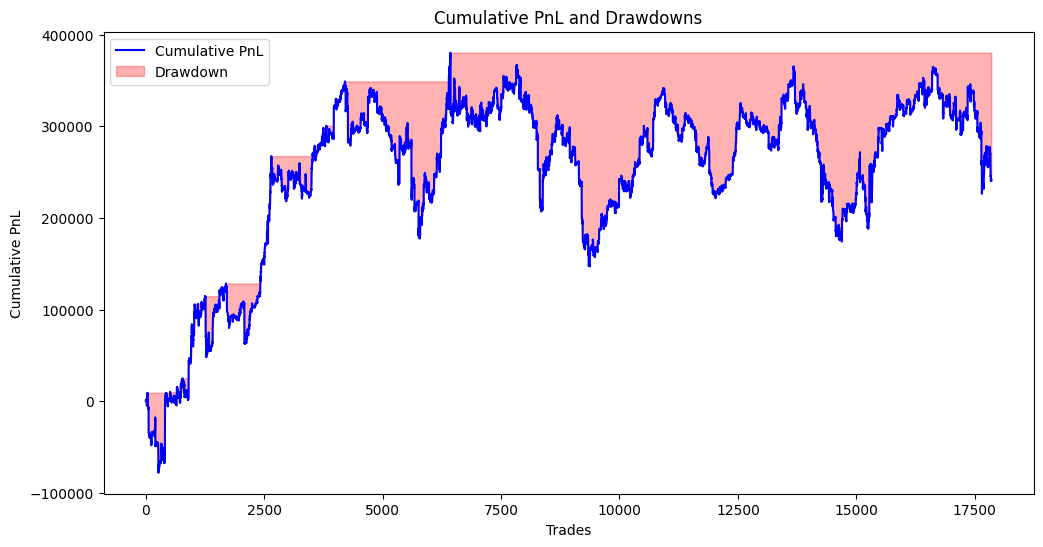

In [25]:
tsla_2022_minute_level_df = minute_bars['TSLA_2022']
tsla_2022_df = calculate_rsi_signal(tsla_2022_minute_level_df)
# Run the backtest
results = backtest_base_strategy(tsla_2022_df)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 2467
Total PnL: 1115379.4039189438
Annualized Sharpe: 2.8664171210735545
Aggregated Win Ratio: 0.4969598702877989
Win Ratio Positive: 0.5072933549432739
Win Ratio Negative: 0.48661800486618007
Profit Factor (Avg_Win / Avg_Loss): 1.4390735545796594
Max Drawdown: 127473.48159585526


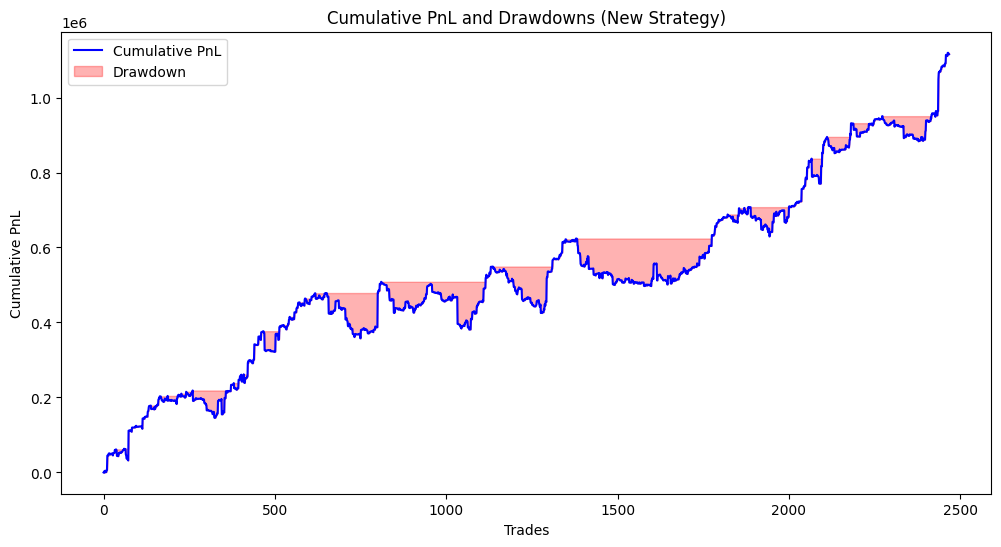

In [26]:
# Run the backtest
tsla_merged_2022 = merge_sentiment(tsla_2022_df,sentiment_data_dict['TSLA_2022'],'TSLA')
tsla_merged_2022 = modify_signal(tsla_merged_2022,'TSLA')
results = backtest_new_strategy(tsla_merged_2022)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

TSLA - 2023

Backtest Results:
Total Trades: 17834
Total PnL: 64700.791560508704
Annualized Sharpe: -0.12918193329868682
Win Ratio: 0.529550297185152
Profit Factor (Avg_Win / Avg_Loss): 0.8978096543530956
Max Drawdown: 394808.1809624641


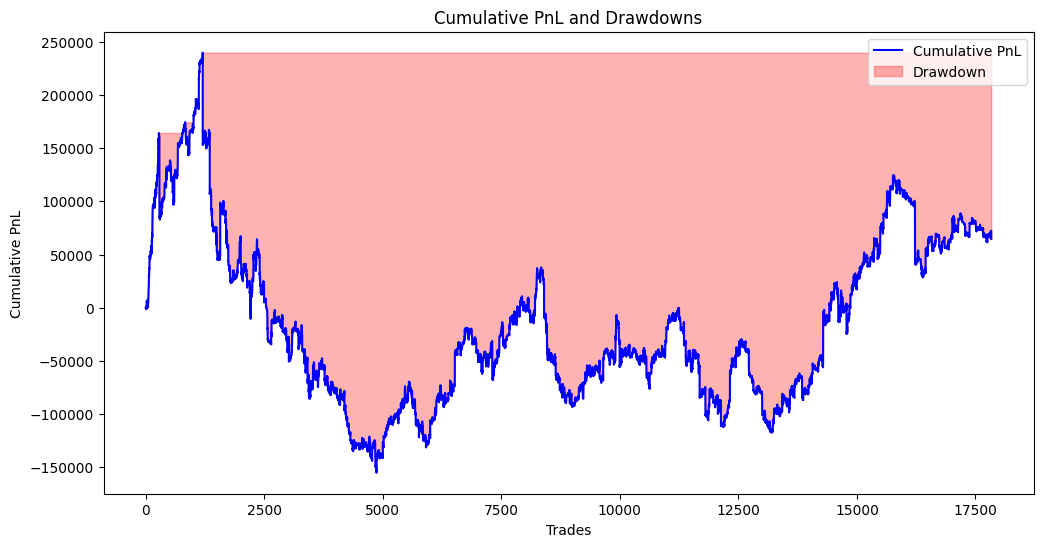

In [27]:
tsla_2023_minute_level_df = minute_bars['TSLA_2023']
tsla_2023_df = calculate_rsi_signal(tsla_2023_minute_level_df)
# Run the backtest
results = backtest_base_strategy(tsla_2023_df)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 2334
Total PnL: 624506.7482032778
Annualized Sharpe: 1.881818507832474
Aggregated Win Ratio: 0.49314481576692376
Win Ratio Positive: 0.4854202401372213
Win Ratio Negative: 0.5008561643835616
Profit Factor (Avg_Win / Avg_Loss): 1.2889494834431894
Max Drawdown: 125447.03681320546


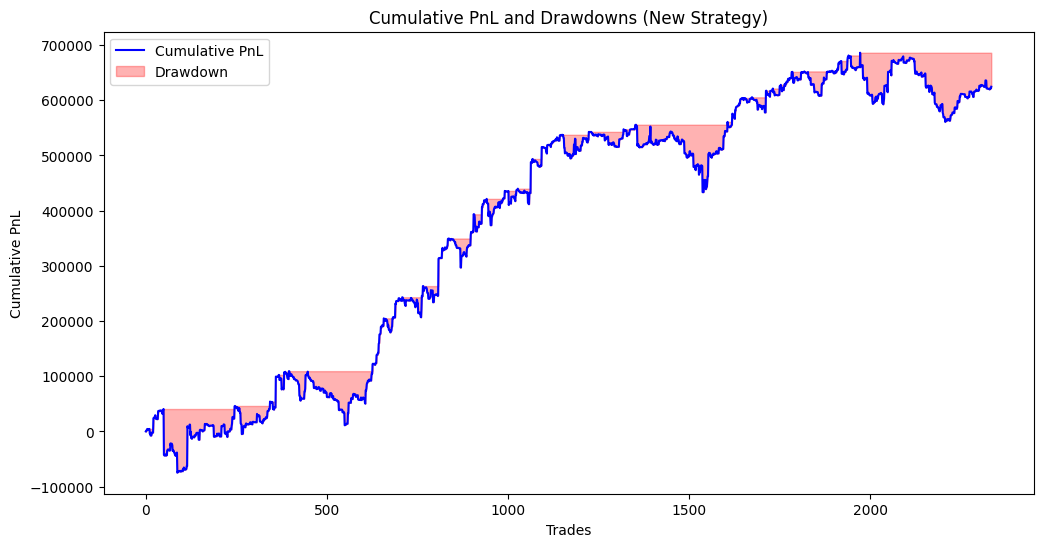

In [28]:
# Run the backtest
tsla_merged_2023 = merge_sentiment(tsla_2023_df,sentiment_data_dict['TSLA_2023'],'TSLA')
tsla_merged_2023 = modify_signal(tsla_merged_2023,'TSLA')
results = backtest_new_strategy(tsla_merged_2023)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

AMZN - 2022

Backtest Results:
Total Trades: 17334
Total PnL: -262527.16441771
Annualized Sharpe: -1.5793468198507346
Win Ratio: 0.49723087573554864
Profit Factor (Avg_Win / Avg_Loss): 0.9604667502379928
Max Drawdown: 352230.22796458186


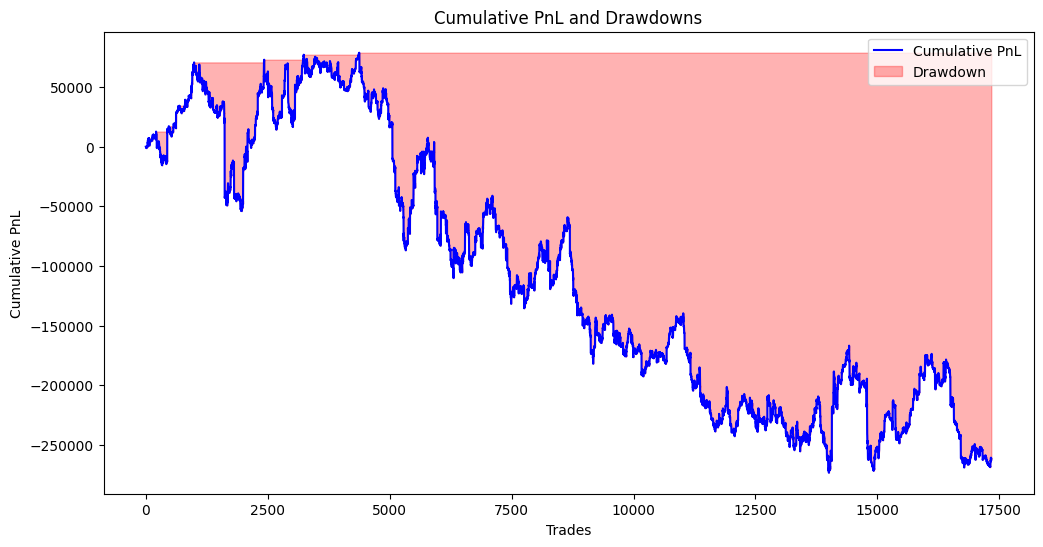

In [29]:
amzn_2022_minute_level_df = minute_bars['AMZN_2022']
amzn_2022_df = calculate_rsi_signal(amzn_2022_minute_level_df)
# Run the backtest
results = backtest_base_strategy(amzn_2022_df)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 924
Total PnL: 601113.4473952849
Annualized Sharpe: 2.3724006761538194
Aggregated Win Ratio: 0.5043290043290043
Win Ratio Positive: 0.5205183585313174
Win Ratio Negative: 0.4880694143167028
Profit Factor (Avg_Win / Avg_Loss): 1.50140723706108
Max Drawdown: 171401.2232043349


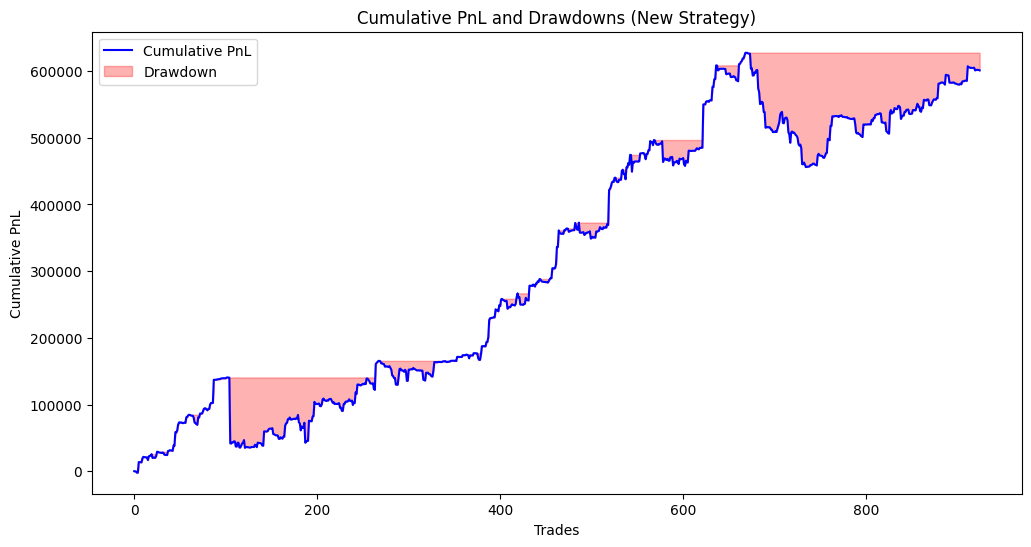

In [30]:
# Run the backtest
amzn_merged_2022 = merge_sentiment(amzn_2022_df,sentiment_data_dict['AMZN_2022'],'AMZN')
amzn_merged_2022 = modify_signal(amzn_merged_2022,'AMZN')
results = backtest_new_strategy(amzn_merged_2022)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

AMZN - 2023

Backtest Results:
Total Trades: 17834
Total PnL: 64700.791560508704
Annualized Sharpe: -0.12918193329868682
Win Ratio: 0.529550297185152
Profit Factor (Avg_Win / Avg_Loss): 0.8978096543530956
Max Drawdown: 394808.1809624641


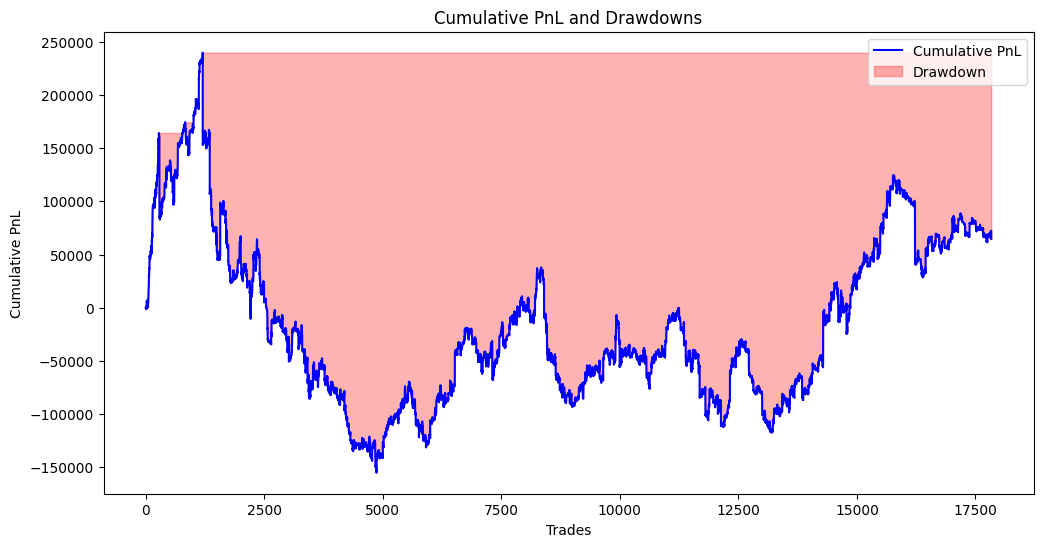

In [31]:
amzn_2023_minute_level_df = minute_bars['AMZN_2023']
amzn_2023_df = calculate_rsi_signal(amzn_2023_minute_level_df)
# Run the backtest
results = backtest_base_strategy(tsla_2023_df)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 666
Total PnL: 420511.15369009145
Annualized Sharpe: 2.4746008902724927
Aggregated Win Ratio: 0.4894894894894895
Win Ratio Positive: 0.4608433734939759
Win Ratio Negative: 0.5179640718562875
Profit Factor (Avg_Win / Avg_Loss): 1.677444955182344
Max Drawdown: 71849.7972980715


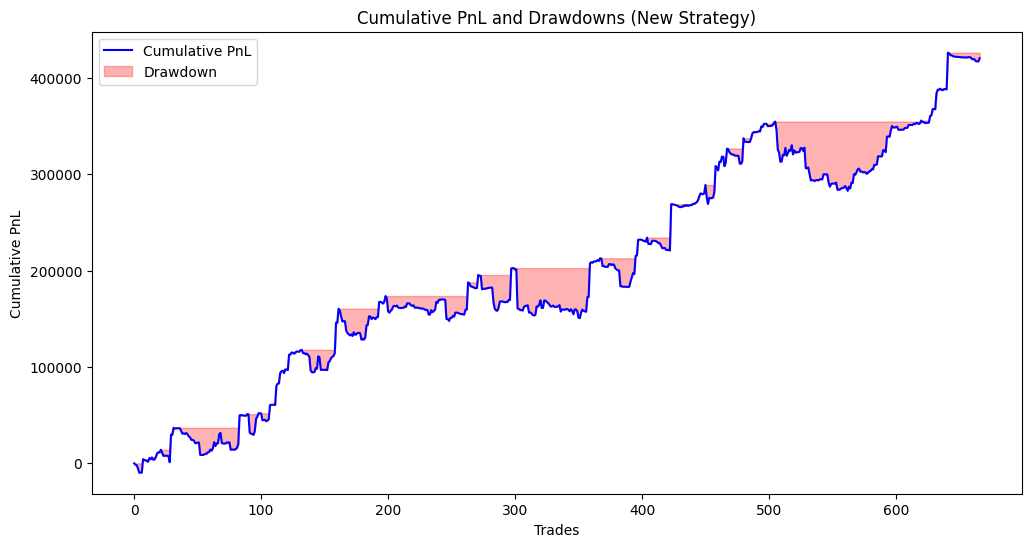

In [32]:
# Run the backtest
amzn_merged_2023 = merge_sentiment(amzn_2023_df,sentiment_data_dict['AMZN_2023'],'AMZN')
amzn_merged_2023 = modify_signal(amzn_merged_2023,'AMZN')
results = backtest_new_strategy(amzn_merged_2023)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 18436
Total PnL: -69224.76509434875
Annualized Sharpe: -0.9760153203017343
Win Ratio: 0.511011065307008
Profit Factor (Avg_Win / Avg_Loss): 0.9401447679374112
Max Drawdown: 205963.33227485727


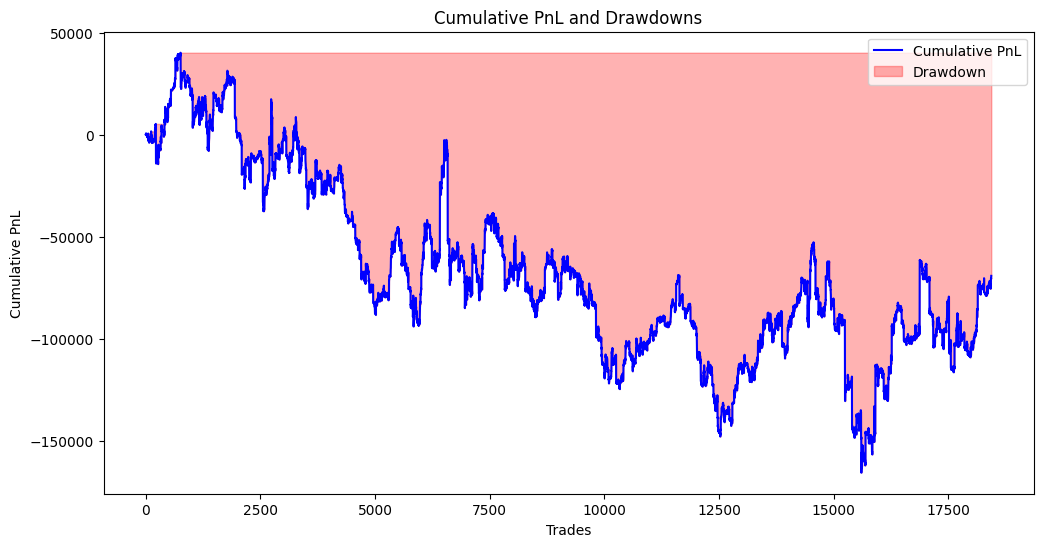

In [33]:
aapl_2022_minute_level_df = minute_bars['AAPL_2022']
aapl_2022_df = calculate_rsi_signal(aapl_2022_minute_level_df)
# Run the backtest
results = backtest_base_strategy(aapl_2022_df)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 1515
Total PnL: 327924.1522118632
Annualized Sharpe: 1.5893922423660929
Aggregated Win Ratio: 0.4884488448844885
Win Ratio Positive: 0.4815303430079156
Win Ratio Negative: 0.4953764861294584
Profit Factor (Avg_Win / Avg_Loss): 1.3792955719058002
Max Drawdown: 113235.00322237812


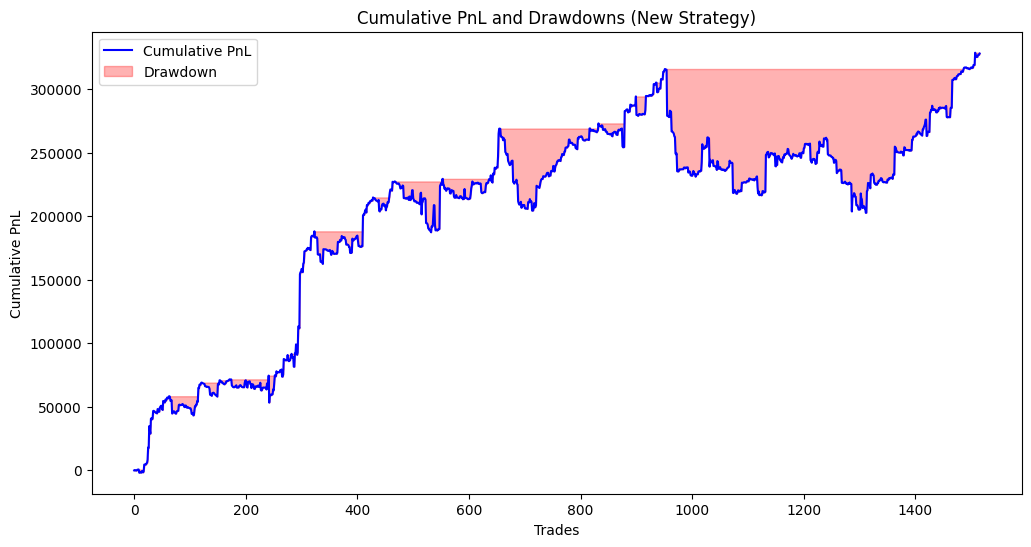

In [34]:
# Run the backtest
aapl_merged_2022 = merge_sentiment(aapl_2022_df,sentiment_data_dict['AAPL_2022'],'AAPL')
aapl_merged_2022 = modify_signal(aapl_merged_2022,'AAPL')
results = backtest_new_strategy(aapl_merged_2022)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

AAPL - 2023

Backtest Results:
Total Trades: 18116
Total PnL: -5624.055131696344
Annualized Sharpe: -0.971132323800687
Win Ratio: 0.49519761536763085
Profit Factor (Avg_Win / Avg_Loss): 1.0148054494508316
Max Drawdown: 124193.49467772702


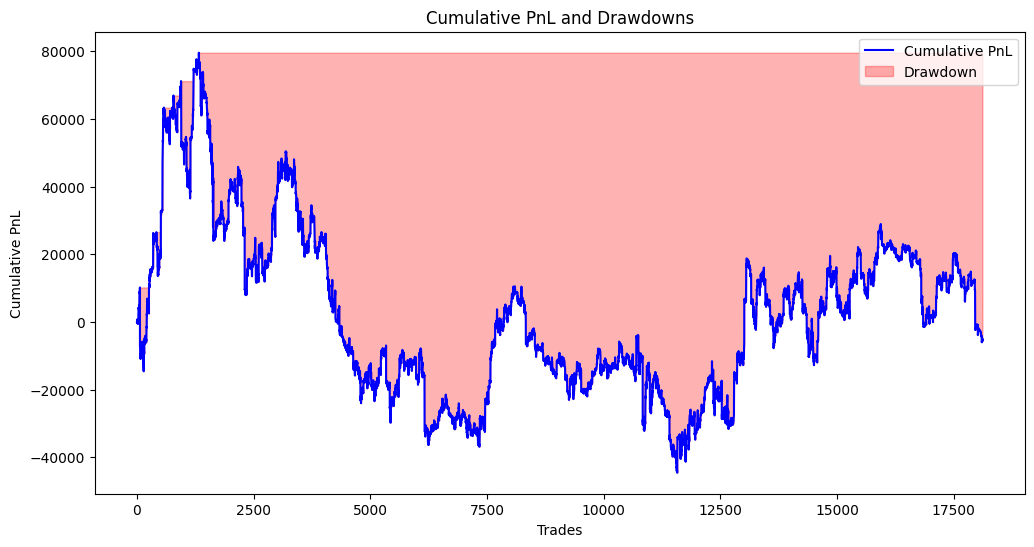

In [35]:
aapl_2023_minute_level_df = minute_bars['AAPL_2023']
aapl_2023_df = calculate_rsi_signal(aapl_2023_minute_level_df)
# Run the backtest
results = backtest_base_strategy(aapl_2023_df)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 1268
Total PnL: 255933.1995679278
Annualized Sharpe: 1.5790031311634825
Aggregated Win Ratio: 0.5094637223974764
Win Ratio Positive: 0.4692913385826772
Win Ratio Negative: 0.5497630331753555
Profit Factor (Avg_Win / Avg_Loss): 1.3028797530537022
Max Drawdown: 88737.4984787172


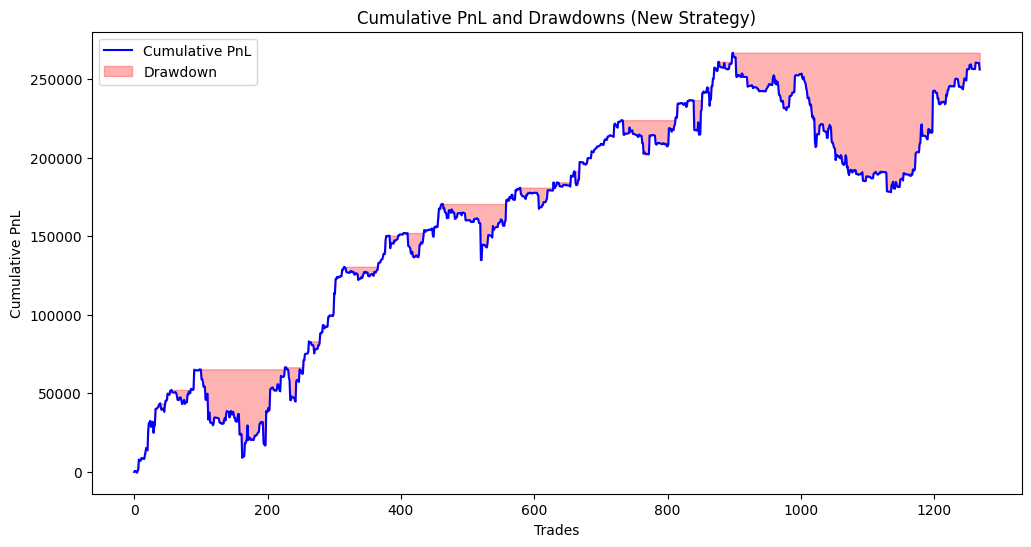

In [36]:
# Run the backtest
aapl_merged_2023 = merge_sentiment(aapl_2023_df,sentiment_data_dict['AAPL_2023'],'AAPL')
aapl_merged_2023 = modify_signal(aapl_merged_2023,'AAPL')
results = backtest_new_strategy(aapl_merged_2023)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

### Stochastic Oscillator Strategy

The **Stochastic Oscillator** is a momentum-based technical indicator that compares a security's closing price to its price range over a specified lookback period. It is designed to identify overbought and oversold conditions, making it particularly effective for range-bound markets.

- **%K Line**: The raw indicator, calculated as the percentage of the current price's position relative to the lowest and highest prices over the lookback period.
- **%D Line**: A smoothed moving average of the %K line, used to generate trading signals.

**Calculation**:
1. **%K Line**:
   \[
   \%K = \frac{(Current\:Close - Lowest\:Low)}{(Highest\:High - Lowest\:Low)} \times 100
   \]
   - **Lowest Low**: Lowest price over the lookback period.
   - **Highest High**: Highest price over the lookback period.

2. **%D Line**:
   - A 3-period Simple Moving Average (SMA) of %K.

**Trading Rules**:
1. **Long**: When the %K line crosses above the %D line below the oversold level (e.g., 20), signaling upward momentum.
2. **Short**: When the %K line crosses below the %D line above the overbought level (e.g., 80), signaling downward momentum.

This strategy leverages the oscillatory behavior of %K and %D to identify potential reversals or confirm existing trends. By balancing responsiveness to price changes with the smoothing effect of moving averages, the Stochastic Oscillator is a versatile tool for short-term, minute-level trading.


In [37]:
def stochastic_signal(df, lookback_period=14, overbought=80, oversold=20):
    """
    Calculates the Stochastic Oscillator and generates trading signals.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'TWAP'.
        lookback_period (int): Lookback period for the Stochastic Oscillator.
        overbought (int): Overbought threshold.
        oversold (int): Oversold threshold.

    Returns:
        pd.DataFrame: DataFrame with %K, %D, and Signal columns.
    """
    # Calculate %K
    df['Lowest_Low'] = df['TWAP'].rolling(window=lookback_period).min()
    df['Highest_High'] = df['TWAP'].rolling(window=lookback_period).max()
    df['%K'] = (df['TWAP'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low']) * 100

    # Calculate %D
    df['%D'] = df['%K'].rolling(window=3).mean()

    # Generate signals
    df['Signal'] = 0
    # Long when %K crosses above %D in oversold zone
    df.loc[(df['%K'] > df['%D']) & (df['%K'].shift(1) <= df['%D'].shift(1)) & (df['%K'] < oversold), 'Signal'] = 1
    # Short when %K crosses below %D in overbought zone
    df.loc[(df['%K'] < df['%D']) & (df['%K'].shift(1) >= df['%D'].shift(1)) & (df['%K'] > overbought), 'Signal'] = -1

    return df


TSLA - 2022

Backtest Results:
Total Trades: 2730
Total PnL: 10411.63516414199
Annualized Sharpe: -0.3864282883505884
Win Ratio: 0.7879120879120879
Profit Factor (Avg_Win / Avg_Loss): 0.26982602881284007
Max Drawdown: 263924.3920436485


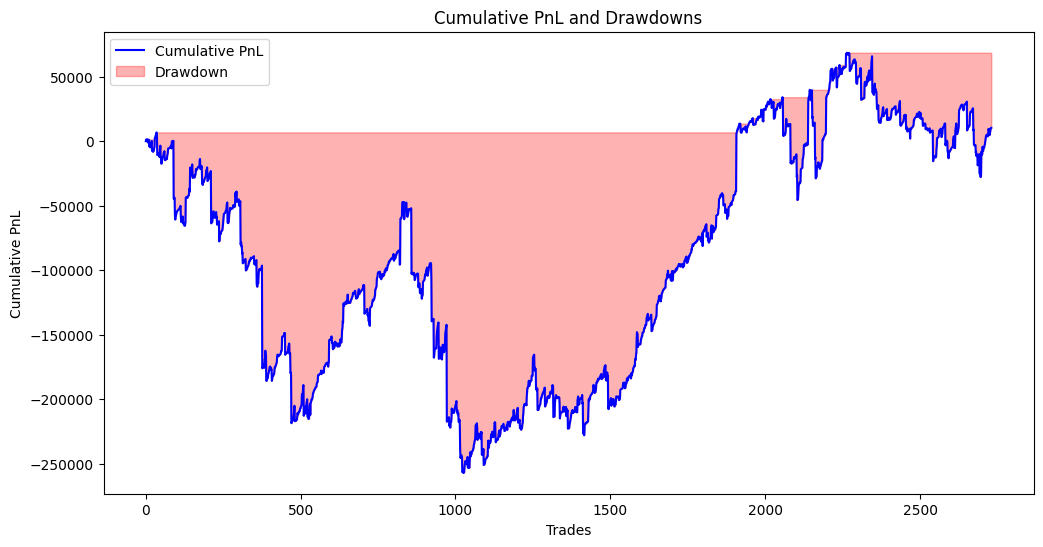

In [38]:
tsla_2022_minute_level_df = minute_bars['TSLA_2022']
tsla_2022_df = stochastic_signal(tsla_2022_minute_level_df)
# Run the backtest
results = backtest_base_strategy(tsla_2022_df)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 345
Total PnL: 555659.491966637
Annualized Sharpe: 2.6263357619989027
Aggregated Win Ratio: 0.6434782608695652
Win Ratio Positive: 0.6820809248554913
Win Ratio Negative: 0.6046511627906976
Profit Factor (Avg_Win / Avg_Loss): 0.9522668180280124
Max Drawdown: 99492.44846802054


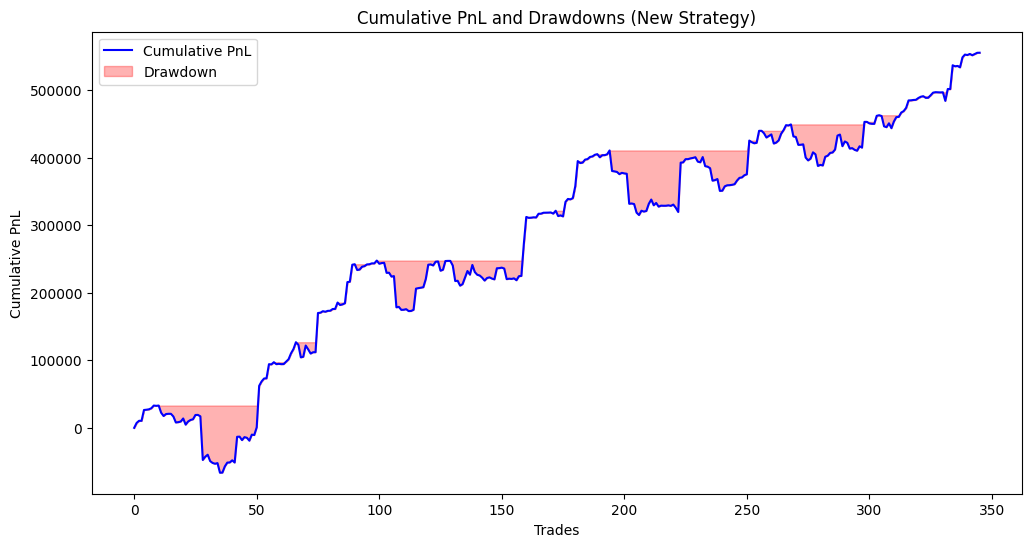

In [39]:
# Run the backtest
tsla_merged_2022 = merge_sentiment(tsla_2022_df,sentiment_data_dict['TSLA_2022'],'TSLA')
tsla_merged_2022 = modify_signal(tsla_merged_2022,'TSLA')
results = backtest_new_strategy(tsla_merged_2022)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

TSLA - 2023

Backtest Results:
Total Trades: 2780
Total PnL: -264080.5844278184
Annualized Sharpe: -1.8237053600192197
Win Ratio: 0.7816546762589928
Profit Factor (Avg_Win / Avg_Loss): 0.24510833537755922
Max Drawdown: 312819.94827552786


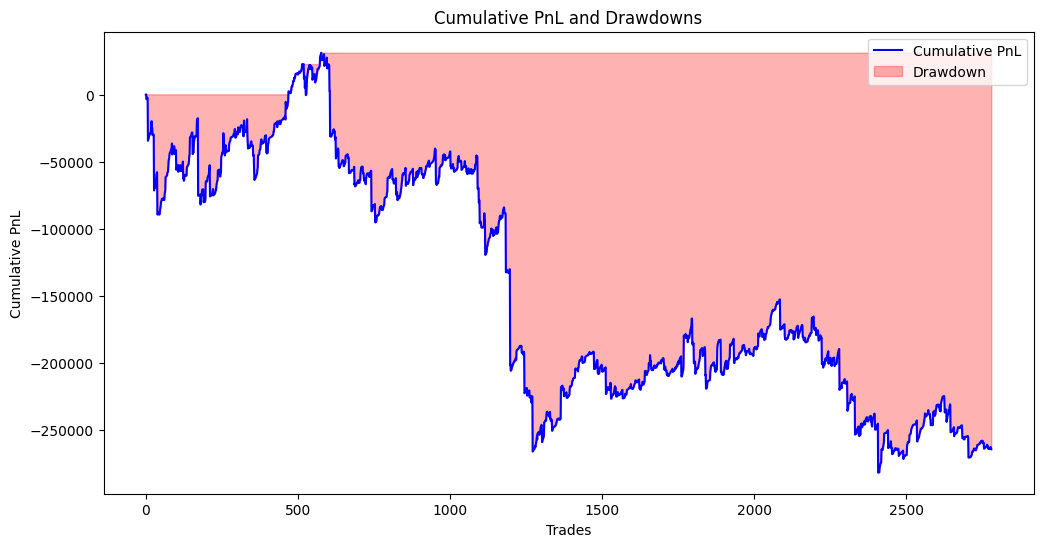

In [40]:
tsla_2023_minute_level_df = minute_bars['TSLA_2023']
tsla_2023_df = stochastic_signal(tsla_2023_minute_level_df)
# Run the backtest
results = backtest_base_strategy(tsla_2023_df)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 340
Total PnL: 239880.89178226455
Annualized Sharpe: 0.954812812241825
Aggregated Win Ratio: 0.6323529411764706
Win Ratio Positive: 0.6140350877192983
Win Ratio Negative: 0.650887573964497
Profit Factor (Avg_Win / Avg_Loss): 0.748376601433685
Max Drawdown: 167892.7477811071


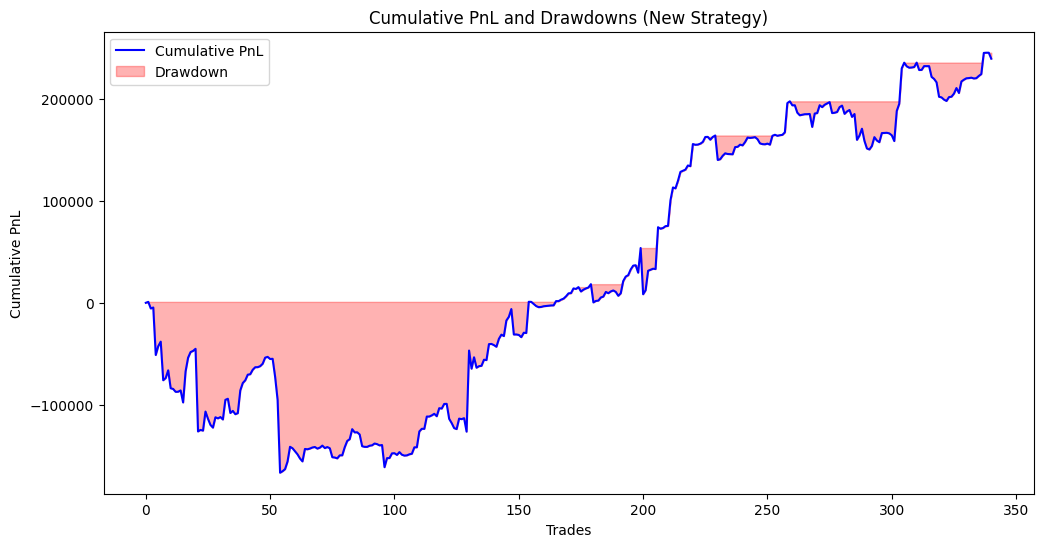

In [41]:
# Run the backtest
tsla_merged_2023 = merge_sentiment(tsla_2023_df,sentiment_data_dict['TSLA_2023'],'TSLA')
tsla_merged_2023 = modify_signal(tsla_merged_2023,'TSLA')
results = backtest_new_strategy(tsla_merged_2023)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

AMZN - 2022

AMZN 2022 Backtest Results:
Total Trades: 2410
Total PnL: -103756.23654184992
Annualized Sharpe: -1.0509859910600965
Win Ratio: 0.7854771784232365
Profit Factor (Avg_Win / Avg_Loss): 0.25676580044713154
Max Drawdown: 249822.23154545188


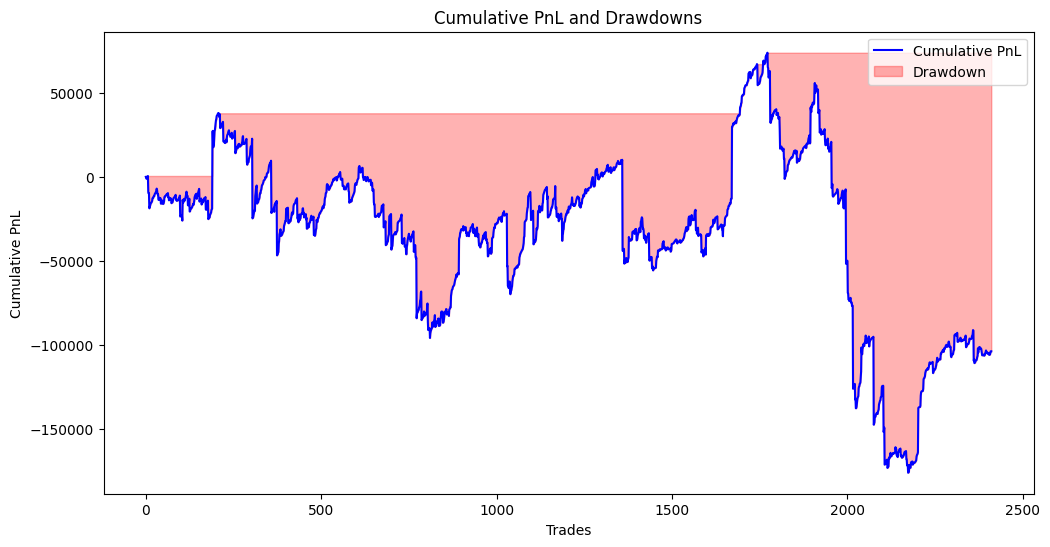

In [42]:
amzn_2022_minute_level_df = minute_bars['AMZN_2022']
amzn_2022_df = stochastic_signal(amzn_2022_minute_level_df)
# Run the backtest
results = backtest_base_strategy(amzn_2022_df)

# Print results
print("AMZN 2022 Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 132
Total PnL: -121656.09928817404
Annualized Sharpe: -1.7951189238428973
Aggregated Win Ratio: 0.5757575757575758
Win Ratio Positive: 0.6119402985074627
Win Ratio Negative: 0.5384615384615384
Profit Factor (Avg_Win / Avg_Loss): 0.5597880345583136
Max Drawdown: 321741.620670891


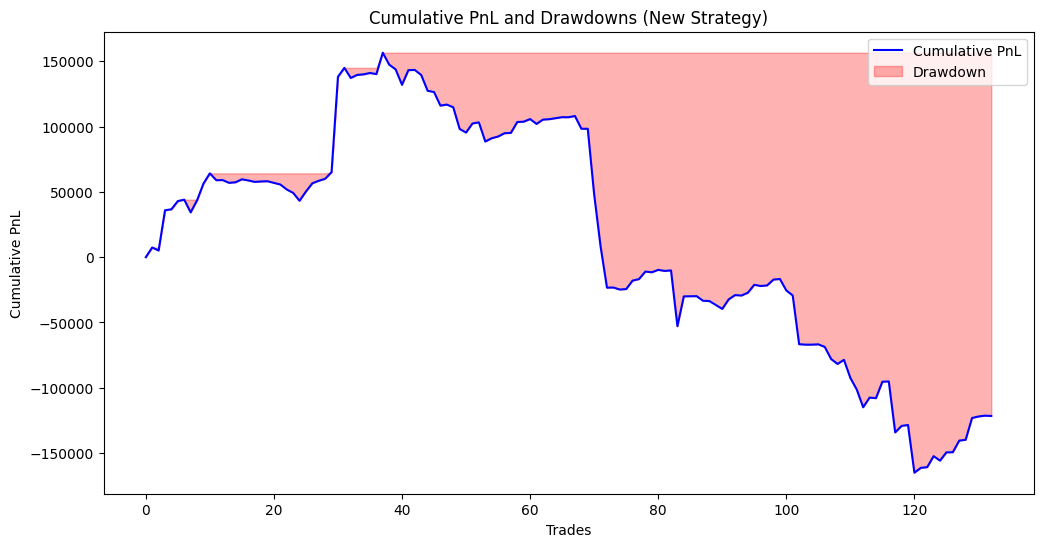

In [43]:
# Run the backtest
amzn_merged_2022 = merge_sentiment(amzn_2022_df,sentiment_data_dict['AMZN_2022'],'AMZN')
amzn_merged_2022 = modify_signal(amzn_merged_2022,'AMZN')
results = backtest_new_strategy(amzn_merged_2022)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

AMZN - 2023

Backtest Results:
Total Trades: 2780
Total PnL: -264080.5844278184
Annualized Sharpe: -1.8237053600192197
Win Ratio: 0.7816546762589928
Profit Factor (Avg_Win / Avg_Loss): 0.24510833537755922
Max Drawdown: 312819.94827552786


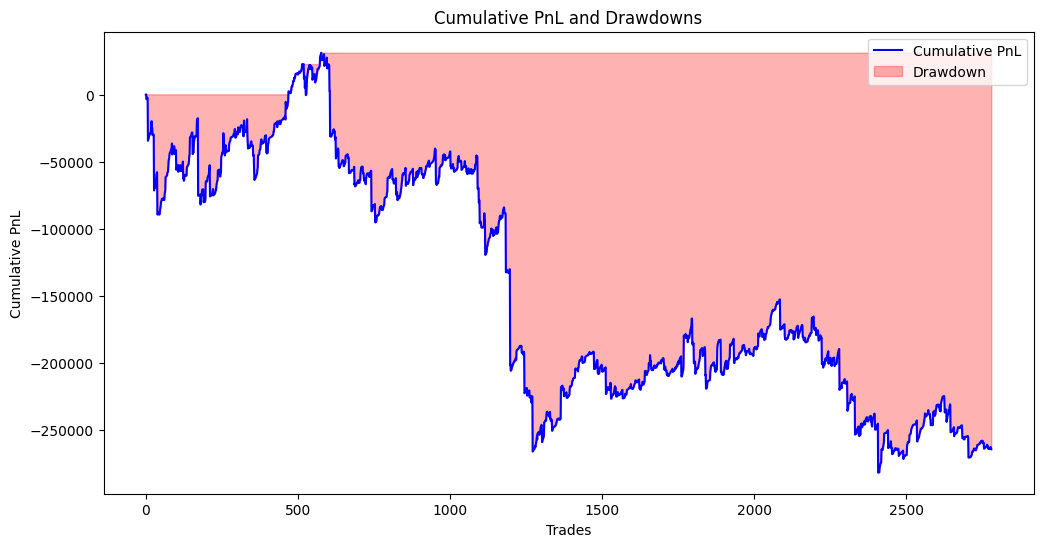

In [44]:
amzn_2023_minute_level_df = minute_bars['AMZN_2023']
amzn_2023_df = stochastic_signal(amzn_2023_minute_level_df)
# Run the backtest
results = backtest_base_strategy(tsla_2023_df)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 103
Total PnL: 18222.64303615726
Annualized Sharpe: -0.2645277351796915
Aggregated Win Ratio: 0.6504854368932039
Win Ratio Positive: 0.5294117647058824
Win Ratio Negative: 0.7692307692307693
Profit Factor (Avg_Win / Avg_Loss): 0.5765696174439079
Max Drawdown: 49141.002444917634


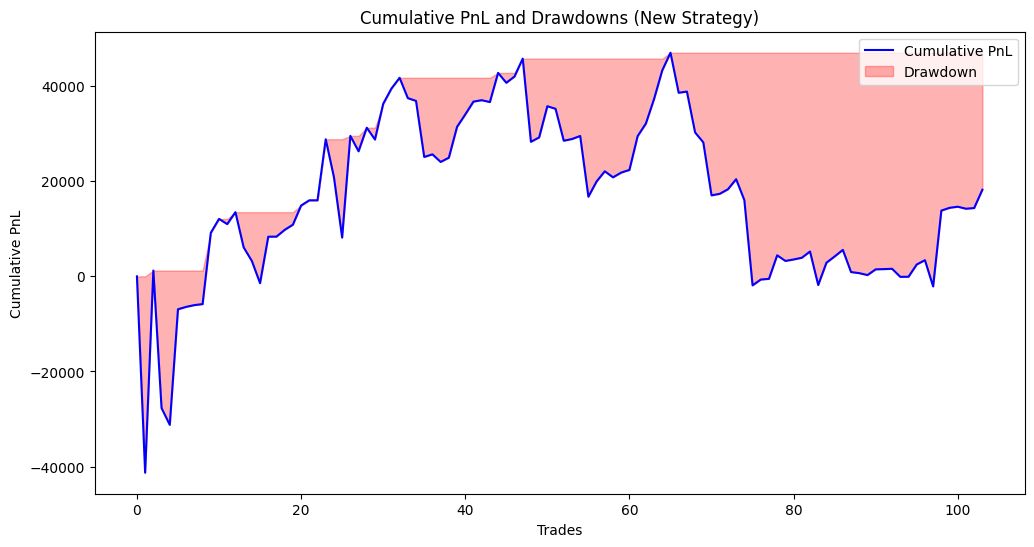

In [45]:
# Run the backtest
amzn_merged_2023 = merge_sentiment(amzn_2023_df,sentiment_data_dict['AMZN_2023'],'AMZN')
amzn_merged_2023 = modify_signal(amzn_merged_2023,'AMZN')
results = backtest_new_strategy(amzn_merged_2023)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

AAPL - 2022

AAPL 2022 Backtest Results:
Total Trades: 2682
Total PnL: 128263.08560450941
Annualized Sharpe: 0.19816725957932851
Win Ratio: 0.7807606263982103
Profit Factor (Avg_Win / Avg_Loss): 0.30969515481689885
Max Drawdown: 68795.89670334136


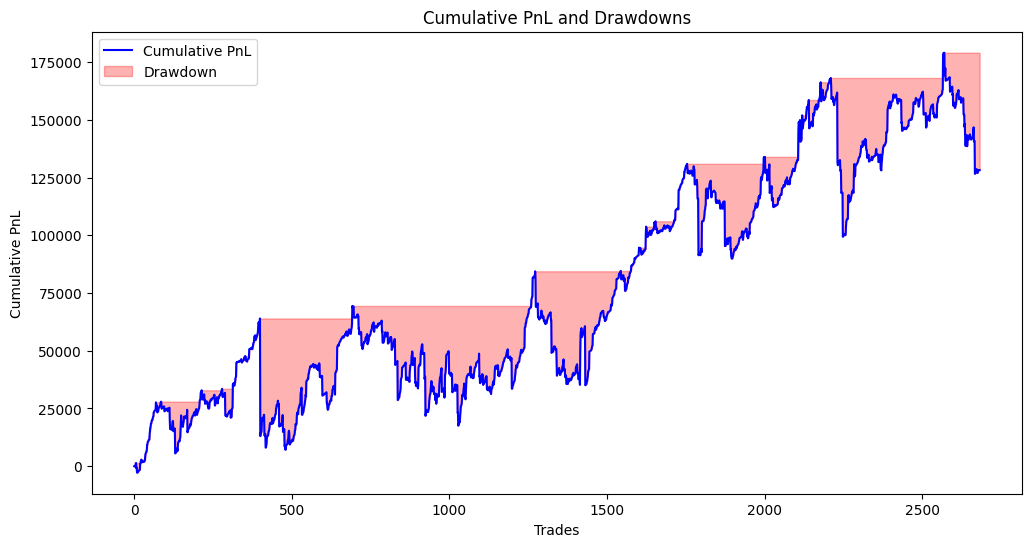

In [46]:
aapl_2022_minute_level_df = minute_bars['AAPL_2022']
aapl_2022_df = stochastic_signal(aapl_2022_minute_level_df)
# Run the backtest
results = backtest_base_strategy(aapl_2022_df)

# Print results
print("AAPL 2022 Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 194
Total PnL: 189107.5494773334
Annualized Sharpe: 1.7909463105019479
Aggregated Win Ratio: 0.6752577319587629
Win Ratio Positive: 0.7083333333333334
Win Ratio Negative: 0.6428571428571429
Profit Factor (Avg_Win / Avg_Loss): 0.7750775590433784
Max Drawdown: 80590.63647963549


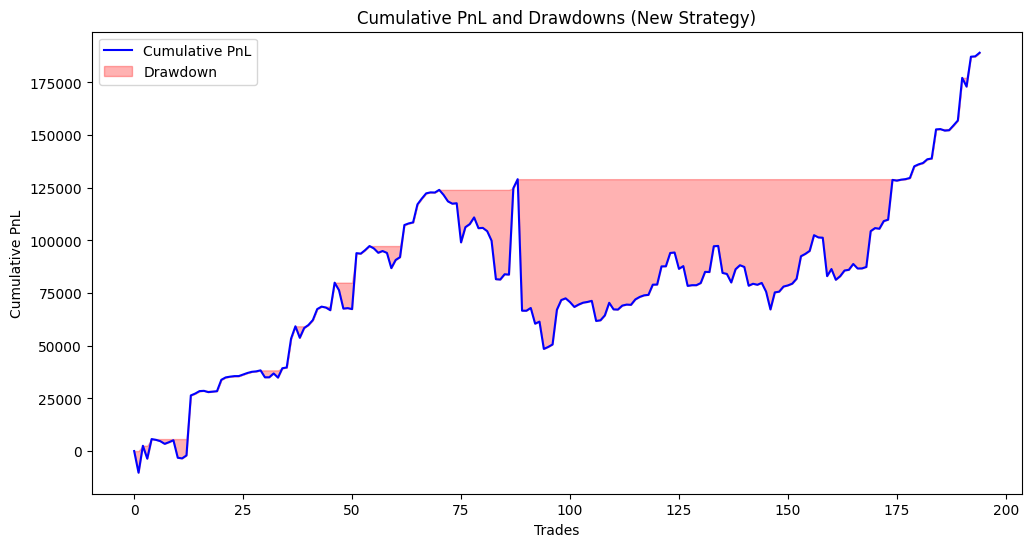

In [47]:
# Run the backtest
aapl_merged_2022 = merge_sentiment(aapl_2022_df,sentiment_data_dict['AAPL_2022'],'AAPL')
aapl_merged_2022 = modify_signal(aapl_merged_2022,'AAPL')
results = backtest_new_strategy(aapl_merged_2022)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

AAPL - 2023

Backtest Results:
Total Trades: 2656
Total PnL: 269627.6961371703
Annualized Sharpe: 2.217595399268572
Win Ratio: 0.7993222891566265
Profit Factor (Avg_Win / Avg_Loss): 0.35484585810181757
Max Drawdown: 48567.36104332861


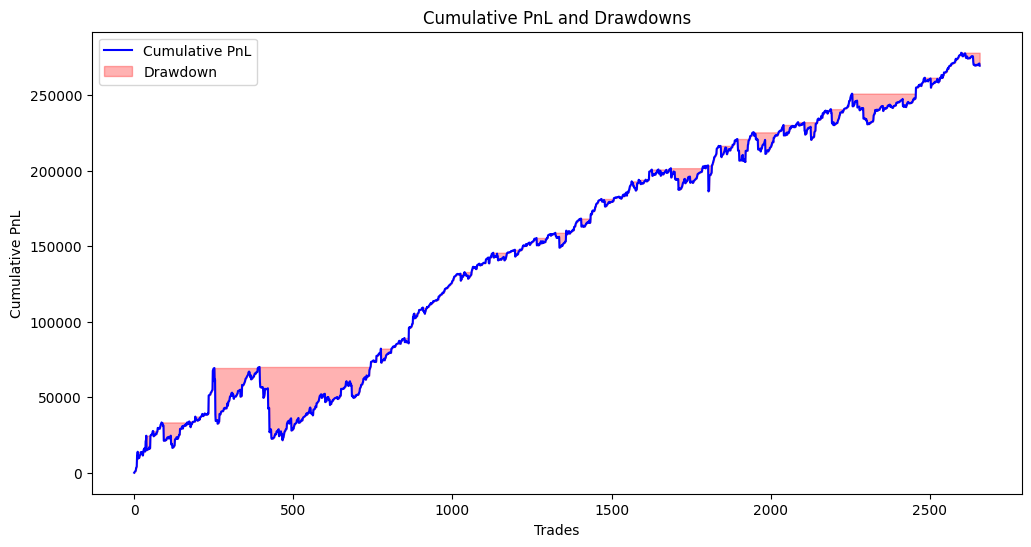

In [48]:
aapl_2023_minute_level_df = minute_bars['AAPL_2023']
aapl_2023_df = stochastic_signal(aapl_2023_minute_level_df)
# Run the backtest
results = backtest_base_strategy(aapl_2023_df)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()

Backtest Results:
Total Trades: 220
Total PnL: 117651.87307671916
Annualized Sharpe: 1.4338891247052108
Aggregated Win Ratio: 0.65
Win Ratio Positive: 0.5779816513761468
Win Ratio Negative: 0.7207207207207207
Profit Factor (Avg_Win / Avg_Loss): 0.8983585680643816
Max Drawdown: 33571.98908441662


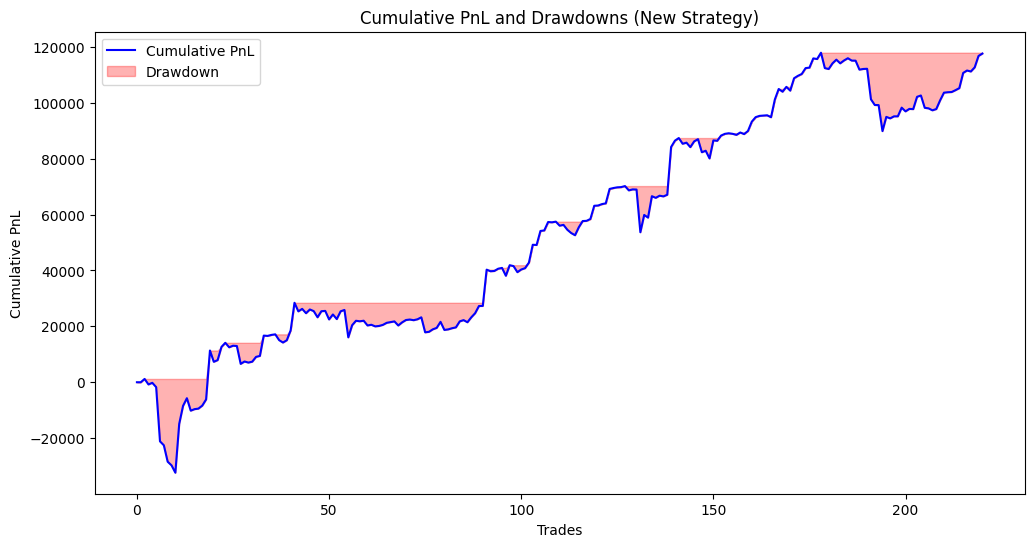

In [49]:
# Run the backtest
aapl_merged_2023 = merge_sentiment(aapl_2023_df,sentiment_data_dict['AAPL_2023'],'AAPL')
aapl_merged_2023 = modify_signal(aapl_merged_2023,'AAPL')
results = backtest_new_strategy(aapl_merged_2023)

# Print results
print("Backtest Results:")
for key, value in results.items():
    if key != 'Cumulative PnL':  # Skip printing the full cumulative PnL
        print(f"{key}: {value}")

# Plot Cumulative PnL and Drawdown
plt.figure(figsize=(12, 6))

# Plot Cumulative PnL
plt.plot(results['Cumulative PnL'], label="Cumulative PnL", color="blue")

# Highlight Drawdowns
cumulative_pnl = results['Cumulative PnL']
peak_pnl = np.maximum.accumulate(cumulative_pnl)
plt.fill_between(range(len(cumulative_pnl)), cumulative_pnl, peak_pnl, color="red", alpha=0.3, label="Drawdown")

plt.title("Cumulative PnL and Drawdowns (New Strategy)")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()